In [869]:
import pandas as pd
from holidays import UnitedStates
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import calendar
import scipy.stats as stats
from scipy.stats import spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pingouin as pg
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc,precision_score, recall_score, f1_score, mean_squared_error, classification_report
from statsmodels.tsa.arima.model import ARIMA


# Datasets Reading

In [814]:
taxi_df = pd.read_csv("dataset.csv", index_col=0)
# Create a new row for 2015-02-01 00:00:00
new_row = {'timestamp': pd.Timestamp('2015-02-01 00:00:00'), 'value': np.nan}

# Append the new row to the original DataFrame
taxi_df.loc[len(taxi_df)] = new_row
taxi_df

timestamp    value
0      2014-07-01 00:00:00  10844.0
1      2014-07-01 00:30:00   8127.0
2      2014-07-01 01:00:00   6210.0
3      2014-07-01 01:30:00   4656.0
4      2014-07-01 02:00:00   3820.0
...                    ...      ...
10316  2015-01-31 22:00:00  25721.0
10317  2015-01-31 22:30:00  27309.0
10318  2015-01-31 23:00:00  26591.0
10319  2015-01-31 23:30:00  26288.0
10320  2015-02-01 00:00:00      NaN

[10321 rows x 2 columns]

In [815]:
print(taxi_df.isnull().sum())
taxi_df.info()

timestamp    0
value        1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 10321 entries, 0 to 10320
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  10321 non-null  object 
 1   value      10320 non-null  float64
dtypes: float64(1), object(1)
memory usage: 241.9+ KB


In [816]:
weather_df = pd.read_csv('weather_csv.csv')
weather_df.head()

timestamp  prep  snow  snow_depth  min_temp  max_temp
0  2014-07-01  0.00   0.0         0.0      72.0      89.0
1  2014-07-02  0.96   0.0         0.0      72.0      91.0
2  2014-07-03  1.78   0.0         0.0      69.0      87.0
3  2014-07-04  0.14   0.0         0.0      65.0      74.0
4  2014-07-05  0.00   0.0         0.0      63.0      81.0

In [817]:
print(weather_df.isnull().sum())
weather_df.info()

timestamp     0
prep          0
snow          0
snow_depth    0
min_temp      0
max_temp      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   216 non-null    object 
 1   prep        216 non-null    float64
 2   snow        216 non-null    float64
 3   snow_depth  216 non-null    float64
 4   min_temp    216 non-null    float64
 5   max_temp    216 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.3+ KB


In [818]:
# Create a holiday object for the US with state-specific holidays for New York
ny_holidays = UnitedStates(years=[2014, 2015], state='NY')

# Convert to a DataFrame
holidays_df = pd.DataFrame({
    "Date": list(ny_holidays.keys()),
    "Holiday": list(ny_holidays.values())
})

# Convert 'Date' to datetime
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

# Filter holidays up to '2015-01-31'
holidays_df = holidays_df.loc[(holidays_df['Date'] <= '2015-01-31') & (holidays_df['Date'] >= '2014-07-01')]

# Sort by index and rename the column "Date" to "timestamp"
holidays_df = holidays_df.sort_values(by=['Date'])

# Show the final DataFrame
holidays_df

Date                     Holiday
2  2014-07-04            Independence Day
3  2014-09-01                   Labor Day
9  2014-10-13                Columbus Day
12 2014-11-04                Election Day
4  2014-11-11                Veterans Day
5  2014-11-27                Thanksgiving
6  2014-12-25               Christmas Day
13 2015-01-01              New Year's Day
21 2015-01-19  Martin Luther King Jr. Day

In [819]:
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df['year'] = taxi_df['timestamp'].dt.year
taxi_df['month'] = taxi_df['timestamp'].dt.month
taxi_df['day'] = taxi_df['timestamp'].dt.day
taxi_df['Date'] = taxi_df['timestamp'].dt.date
taxi_df['Date'] = taxi_df['Date'].apply(pd.to_datetime).dt.date
taxi_df['day_of_week'] = taxi_df['timestamp'].dt.day_of_week + 1
taxi_df['hour'] = taxi_df['timestamp'].dt.hour
taxi_df['isWeekend'] = taxi_df.day_of_week.map({1: False, 2: False, 3: False, 4: False, 5: False, 6: True, 7: True})
taxi_df['day_of_week'] = taxi_df['day_of_week'].map({1: 'Monday', 2:'Tuesday'
                                                     , 3:'Wednesday', 4:"Thursday", 5: 'Friday',
                                                     6: 'Saturday', 7: 'Sunday'})

# Add time parts to the anomaly dates and update the 'isAnomaly' column
taxi_df['isAnomaly'] = False
anomaly_dates = ['2014-11-02', '2014-11-27', '2014-12-24', '2014-12-25', '2015-01-01', '2015-01-26', '2015-01-27']

anomaly_dates = [pd.to_datetime(date).date() for date in anomaly_dates]
taxi_df['isAnomaly'] = taxi_df['Date'].isin(anomaly_dates)

# View the dataset for verification
taxi_df.loc[taxi_df['isAnomaly']][['Date', 'isAnomaly']]

Date  isAnomaly
5952   2014-11-02       True
5953   2014-11-02       True
5954   2014-11-02       True
5955   2014-11-02       True
5956   2014-11-02       True
...           ...        ...
10123  2015-01-27       True
10124  2015-01-27       True
10125  2015-01-27       True
10126  2015-01-27       True
10127  2015-01-27       True

[336 rows x 2 columns]

In [820]:
taxi_df

timestamp    value  year  month  day        Date day_of_week  \
0     2014-07-01 00:00:00  10844.0  2014      7    1  2014-07-01     Tuesday   
1     2014-07-01 00:30:00   8127.0  2014      7    1  2014-07-01     Tuesday   
2     2014-07-01 01:00:00   6210.0  2014      7    1  2014-07-01     Tuesday   
3     2014-07-01 01:30:00   4656.0  2014      7    1  2014-07-01     Tuesday   
4     2014-07-01 02:00:00   3820.0  2014      7    1  2014-07-01     Tuesday   
...                   ...      ...   ...    ...  ...         ...         ...   
10316 2015-01-31 22:00:00  25721.0  2015      1   31  2015-01-31    Saturday   
10317 2015-01-31 22:30:00  27309.0  2015      1   31  2015-01-31    Saturday   
10318 2015-01-31 23:00:00  26591.0  2015      1   31  2015-01-31    Saturday   
10319 2015-01-31 23:30:00  26288.0  2015      1   31  2015-01-31    Saturday   
10320 2015-02-01 00:00:00      NaN  2015      2    1  2015-02-01      Sunday   

       hour  isWeekend  isAnomaly  
0         0      False      False  
1         0      False      False  
2         1      False      False  
3         1      False      False  
4         2      False      False  
...     ...        ...        ...  
10316    22       True      False  
10317    22       True      False  
10318    23       True      False  
10319    23       True      False  
10320     0       True      False  

[10321 rows x 10 columns]

Merging datasets

In [821]:
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
taxi_df['Date'] = pd.to_datetime(taxi_df['Date'])
merged_data = pd.merge(taxi_df, holidays_df, how='left', on='Date')

weather_df['timestamp'] = weather_df['timestamp'] + ' 00:00:00'
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'] + ' 00:00:00')
weather_df['timestamp'] = weather_df['timestamp'].dt.normalize()
weather_df
merged_data = pd.merge(merged_data, weather_df, how='left', on='timestamp')
merged_data.loc[~merged_data['Holiday'].isnull()]

C:\Users\weare\AppData\Local\Temp\ipykernel_12792\2614963403.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'] + ' 00:00:00')


timestamp    value  year  month  day       Date day_of_week  \
144  2014-07-04 00:00:00  15591.0  2014      7    4 2014-07-04      Friday   
145  2014-07-04 00:30:00  14395.0  2014      7    4 2014-07-04      Friday   
146  2014-07-04 01:00:00  12535.0  2014      7    4 2014-07-04      Friday   
147  2014-07-04 01:30:00  11341.0  2014      7    4 2014-07-04      Friday   
148  2014-07-04 02:00:00   9980.0  2014      7    4 2014-07-04      Friday   
...                  ...      ...   ...    ...  ...        ...         ...   
9739 2015-01-19 21:30:00  14069.0  2015      1   19 2015-01-19      Monday   
9740 2015-01-19 22:00:00  13506.0  2015      1   19 2015-01-19      Monday   
9741 2015-01-19 22:30:00  12936.0  2015      1   19 2015-01-19      Monday   
9742 2015-01-19 23:00:00  10400.0  2015      1   19 2015-01-19      Monday   
9743 2015-01-19 23:30:00   8189.0  2015      1   19 2015-01-19      Monday   

      hour  isWeekend  isAnomaly                     Holiday  prep  snow  \
144      0      False      False            Independence Day  0.14   0.0   
145      0      False      False            Independence Day   NaN   NaN   
146      1      False      False            Independence Day   NaN   NaN   
147      1      False      False            Independence Day   NaN   NaN   
148      2      False      False            Independence Day   NaN   NaN   
...    ...        ...        ...                         ...   ...   ...   
9739    21      False      False  Martin Luther King Jr. Day   NaN   NaN   
9740    22      False      False  Martin Luther King Jr. Day   NaN   NaN   
9741    22      False      False  Martin Luther King Jr. Day   NaN   NaN   
9742    23      False      False  Martin Luther King Jr. Day   NaN   NaN   
9743    23      False      False  Martin Luther King Jr. Day   NaN   NaN   

      snow_depth  min_temp  max_temp  
144          0.0      65.0      74.0  
145          NaN       NaN       NaN  
146          NaN       NaN       NaN  
147          NaN       NaN       NaN  
148          NaN       NaN       NaN  
...          ...       ...       ...  
9739         NaN       NaN       NaN  
9740         NaN       NaN       NaN  
9741         NaN       NaN       NaN  
9742         NaN       NaN       NaN  
9743         NaN       NaN       NaN  

[432 rows x 16 columns]

In [822]:
dataset = merged_data.copy()
dataset

timestamp    value  year  month  day       Date day_of_week  \
0     2014-07-01 00:00:00  10844.0  2014      7    1 2014-07-01     Tuesday   
1     2014-07-01 00:30:00   8127.0  2014      7    1 2014-07-01     Tuesday   
2     2014-07-01 01:00:00   6210.0  2014      7    1 2014-07-01     Tuesday   
3     2014-07-01 01:30:00   4656.0  2014      7    1 2014-07-01     Tuesday   
4     2014-07-01 02:00:00   3820.0  2014      7    1 2014-07-01     Tuesday   
...                   ...      ...   ...    ...  ...        ...         ...   
10316 2015-01-31 22:00:00  25721.0  2015      1   31 2015-01-31    Saturday   
10317 2015-01-31 22:30:00  27309.0  2015      1   31 2015-01-31    Saturday   
10318 2015-01-31 23:00:00  26591.0  2015      1   31 2015-01-31    Saturday   
10319 2015-01-31 23:30:00  26288.0  2015      1   31 2015-01-31    Saturday   
10320 2015-02-01 00:00:00      NaN  2015      2    1 2015-02-01      Sunday   

       hour  isWeekend  isAnomaly Holiday  prep  snow  snow_depth  min_temp  \
0         0      False      False     NaN  0.00   0.0         0.0      72.0   
1         0      False      False     NaN   NaN   NaN         NaN       NaN   
2         1      False      False     NaN   NaN   NaN         NaN       NaN   
3         1      False      False     NaN   NaN   NaN         NaN       NaN   
4         2      False      False     NaN   NaN   NaN         NaN       NaN   
...     ...        ...        ...     ...   ...   ...         ...       ...   
10316    22       True      False     NaN   NaN   NaN         NaN       NaN   
10317    22       True      False     NaN   NaN   NaN         NaN       NaN   
10318    23       True      False     NaN   NaN   NaN         NaN       NaN   
10319    23       True      False     NaN   NaN   NaN         NaN       NaN   
10320     0       True      False     NaN  0.03   0.3         5.9      20.0   

       max_temp  
0          89.0  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
10316       NaN  
10317       NaN  
10318       NaN  
10319       NaN  
10320      36.0  

[10321 rows x 16 columns]

Filling the missing values

In [823]:
dataset = dataset[['timestamp','value','month','day','hour','day_of_week','isWeekend','isAnomaly','Holiday','prep','snow','snow_depth','min_temp','max_temp']]
dataset['isHoliday'] = False
dataset.loc[~dataset['Holiday'].isnull(),'isHoliday'] = True
dataset

C:\Users\weare\AppData\Local\Temp\ipykernel_12792\2121259570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['isHoliday'] = False


timestamp    value  month  day  hour day_of_week  isWeekend  \
0     2014-07-01 00:00:00  10844.0      7    1     0     Tuesday      False   
1     2014-07-01 00:30:00   8127.0      7    1     0     Tuesday      False   
2     2014-07-01 01:00:00   6210.0      7    1     1     Tuesday      False   
3     2014-07-01 01:30:00   4656.0      7    1     1     Tuesday      False   
4     2014-07-01 02:00:00   3820.0      7    1     2     Tuesday      False   
...                   ...      ...    ...  ...   ...         ...        ...   
10316 2015-01-31 22:00:00  25721.0      1   31    22    Saturday       True   
10317 2015-01-31 22:30:00  27309.0      1   31    22    Saturday       True   
10318 2015-01-31 23:00:00  26591.0      1   31    23    Saturday       True   
10319 2015-01-31 23:30:00  26288.0      1   31    23    Saturday       True   
10320 2015-02-01 00:00:00      NaN      2    1     0      Sunday       True   

       isAnomaly Holiday  prep  snow  snow_depth  min_temp  max_temp  \
0          False     NaN  0.00   0.0         0.0      72.0      89.0   
1          False     NaN   NaN   NaN         NaN       NaN       NaN   
2          False     NaN   NaN   NaN         NaN       NaN       NaN   
3          False     NaN   NaN   NaN         NaN       NaN       NaN   
4          False     NaN   NaN   NaN         NaN       NaN       NaN   
...          ...     ...   ...   ...         ...       ...       ...   
10316      False     NaN   NaN   NaN         NaN       NaN       NaN   
10317      False     NaN   NaN   NaN         NaN       NaN       NaN   
10318      False     NaN   NaN   NaN         NaN       NaN       NaN   
10319      False     NaN   NaN   NaN         NaN       NaN       NaN   
10320      False     NaN  0.03   0.3         5.9      20.0      36.0   

       isHoliday  
0          False  
1          False  
2          False  
3          False  
4          False  
...          ...  
10316      False  
10317      False  
10318      False  
10319      False  
10320      False  

[10321 rows x 15 columns]

In [824]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.set_index("timestamp", inplace=True)
print(dataset.isnull().sum())
print()
dataset.describe()

value              1
month              0
day                0
hour               0
day_of_week        0
isWeekend          0
isAnomaly          0
Holiday         9889
prep           10105
snow           10105
snow_depth     10105
min_temp       10105
max_temp       10105
isHoliday          0
dtype: int64



C:\Users\weare\AppData\Local\Temp\ipykernel_12792\1555961628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])


value         month           day          hour        prep  \
count  10320.000000  10321.000000  10321.000000  10321.000000  216.000000   
mean   15137.569380      8.269160     15.859025     11.498886    0.141806   
std     6939.495808      3.379261      8.868658      6.923112    0.366058   
min        8.000000      1.000000      1.000000      0.000000    0.000000   
25%    10262.000000      7.000000      8.000000      5.000000    0.000000   
50%    16778.000000      9.000000     16.000000     11.000000    0.000000   
75%    19838.750000     11.000000     24.000000     17.000000    0.060000   
max    39197.000000     12.000000     31.000000     23.000000    2.540000   

             snow  snow_depth    min_temp    max_temp  
count  216.000000  216.000000  216.000000  216.000000  
mean     0.085185    0.248611   49.777778   62.995370  
std      0.552005    1.191598   17.416823   19.140484  
min      0.000000    0.000000    8.000000   21.000000  
25%      0.000000    0.000000   35.000000   44.750000  
50%      0.000000    0.000000   52.500000   67.000000  
75%      0.000000    0.000000   65.250000   81.000000  
max      5.500000    7.900000   77.000000   92.000000

In [825]:
dataset

value  month  day  hour day_of_week  isWeekend  \
timestamp                                                               
2014-07-01 00:00:00  10844.0      7    1     0     Tuesday      False   
2014-07-01 00:30:00   8127.0      7    1     0     Tuesday      False   
2014-07-01 01:00:00   6210.0      7    1     1     Tuesday      False   
2014-07-01 01:30:00   4656.0      7    1     1     Tuesday      False   
2014-07-01 02:00:00   3820.0      7    1     2     Tuesday      False   
...                      ...    ...  ...   ...         ...        ...   
2015-01-31 22:00:00  25721.0      1   31    22    Saturday       True   
2015-01-31 22:30:00  27309.0      1   31    22    Saturday       True   
2015-01-31 23:00:00  26591.0      1   31    23    Saturday       True   
2015-01-31 23:30:00  26288.0      1   31    23    Saturday       True   
2015-02-01 00:00:00      NaN      2    1     0      Sunday       True   

                     isAnomaly Holiday  prep  snow  snow_depth  min_temp  \
timestamp                                                                  
2014-07-01 00:00:00      False     NaN  0.00   0.0         0.0      72.0   
2014-07-01 00:30:00      False     NaN   NaN   NaN         NaN       NaN   
2014-07-01 01:00:00      False     NaN   NaN   NaN         NaN       NaN   
2014-07-01 01:30:00      False     NaN   NaN   NaN         NaN       NaN   
2014-07-01 02:00:00      False     NaN   NaN   NaN         NaN       NaN   
...                        ...     ...   ...   ...         ...       ...   
2015-01-31 22:00:00      False     NaN   NaN   NaN         NaN       NaN   
2015-01-31 22:30:00      False     NaN   NaN   NaN         NaN       NaN   
2015-01-31 23:00:00      False     NaN   NaN   NaN         NaN       NaN   
2015-01-31 23:30:00      False     NaN   NaN   NaN         NaN       NaN   
2015-02-01 00:00:00      False     NaN  0.03   0.3         5.9      20.0   

                     max_temp  isHoliday  
timestamp                                 
2014-07-01 00:00:00      89.0      False  
2014-07-01 00:30:00       NaN      False  
2014-07-01 01:00:00       NaN      False  
2014-07-01 01:30:00       NaN      False  
2014-07-01 02:00:00       NaN      False  
...                       ...        ...  
2015-01-31 22:00:00       NaN      False  
2015-01-31 22:30:00       NaN      False  
2015-01-31 23:00:00       NaN      False  
2015-01-31 23:30:00       NaN      False  
2015-02-01 00:00:00      36.0      False  

[10321 rows x 14 columns]

# Data Preparation & Preprocessing

In [826]:
# Perform interpolation for specific columns
columns_to_interpolate = ['prep', 'snow', 'snow_depth', 'min_temp', 'max_temp']

# Interpolate only within ranges defined by 00:00:00 timestamps
dataset[columns_to_interpolate] = dataset[columns_to_interpolate].interpolate(method='time')
# Remove the row with index '2015-02-01 00:00:00'
dataset = dataset.drop(pd.Timestamp('2015-02-01 00:00:00'))

dataset.loc[dataset['Holiday'].isnull(), 'Holiday'] = 'None' # in string
dataset["month"] = dataset["month"].apply(lambda x: calendar.month_name[x])
dataset['value'] = dataset['value'].astype(int)
dataset['range_temp'] = abs(dataset['max_temp'] - dataset['min_temp'])
dataset

C:\Users\weare\AppData\Local\Temp\ipykernel_12792\2377225724.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[columns_to_interpolate] = dataset[columns_to_interpolate].interpolate(method='time')


value    month  day  hour day_of_week  isWeekend  \
timestamp                                                               
2014-07-01 00:00:00  10844     July    1     0     Tuesday      False   
2014-07-01 00:30:00   8127     July    1     0     Tuesday      False   
2014-07-01 01:00:00   6210     July    1     1     Tuesday      False   
2014-07-01 01:30:00   4656     July    1     1     Tuesday      False   
2014-07-01 02:00:00   3820     July    1     2     Tuesday      False   
...                    ...      ...  ...   ...         ...        ...   
2015-01-31 21:30:00  24670  January   31    21    Saturday       True   
2015-01-31 22:00:00  25721  January   31    22    Saturday       True   
2015-01-31 22:30:00  27309  January   31    22    Saturday       True   
2015-01-31 23:00:00  26591  January   31    23    Saturday       True   
2015-01-31 23:30:00  26288  January   31    23    Saturday       True   

                     isAnomaly Holiday      prep     snow  snow_depth  \
timestamp                                                               
2014-07-01 00:00:00      False    None  0.000000  0.00000       0.000   
2014-07-01 00:30:00      False    None  0.020000  0.00000       0.000   
2014-07-01 01:00:00      False    None  0.040000  0.00000       0.000   
2014-07-01 01:30:00      False    None  0.060000  0.00000       0.000   
2014-07-01 02:00:00      False    None  0.080000  0.00000       0.000   
...                        ...     ...       ...      ...         ...   
2015-01-31 21:30:00      False    None  0.026875  0.26875       6.025   
2015-01-31 22:00:00      False    None  0.027500  0.27500       6.000   
2015-01-31 22:30:00      False    None  0.028125  0.28125       5.975   
2015-01-31 23:00:00      False    None  0.028750  0.28750       5.950   
2015-01-31 23:30:00      False    None  0.029375  0.29375       5.925   

                      min_temp   max_temp  isHoliday  range_temp  
timestamp                                                         
2014-07-01 00:00:00  72.000000  89.000000      False   17.000000  
2014-07-01 00:30:00  72.000000  89.041667      False   17.041667  
2014-07-01 01:00:00  72.000000  89.083333      False   17.083333  
2014-07-01 01:30:00  72.000000  89.125000      False   17.125000  
2014-07-01 02:00:00  72.000000  89.166667      False   17.166667  
...                        ...        ...        ...         ...  
2015-01-31 21:30:00  19.270833  34.958333      False   15.687500  
2015-01-31 22:00:00  19.416667  35.166667      False   15.750000  
2015-01-31 22:30:00  19.562500  35.375000      False   15.812500  
2015-01-31 23:00:00  19.708333  35.583333      False   15.875000  
2015-01-31 23:30:00  19.854167  35.791667      False   15.937500  

[10320 rows x 15 columns]

In [827]:
print(dataset.isnull().sum())
print()
dataset.describe()

value          0
month          0
day            0
hour           0
day_of_week    0
isWeekend      0
isAnomaly      0
Holiday        0
prep           0
snow           0
snow_depth     0
min_temp       0
max_temp       0
isHoliday      0
range_temp     0
dtype: int64



value           day          hour          prep          snow  \
count  10320.000000  10320.000000  10320.000000  10320.000000  10320.000000   
mean   15137.569380     15.860465     11.500000      0.142394      0.084869   
std     6939.495808      8.867881      6.922522      0.303623      0.487209   
min        8.000000      1.000000      0.000000      0.000000      0.000000   
25%    10262.000000      8.000000      5.750000      0.000000      0.000000   
50%    16778.000000     16.000000     11.500000      0.007500      0.000000   
75%    19838.750000     24.000000     17.250000      0.126667      0.000000   
max    39197.000000     31.000000     23.000000      2.540000      5.500000   

         snow_depth      min_temp      max_temp    range_temp  
count  10320.000000  10320.000000  10320.000000  10320.000000  
mean       0.235761     49.797868     63.000242     13.202374  
std        1.138648     17.166381     18.863386      4.073228  
min        0.000000      8.000000     21.000000      3.000000  
25%        0.000000     34.958333     44.750000     10.348958  
50%        0.000000     52.250000     66.416667     13.333333  
75%        0.000000     65.484375     80.916667     16.166667  
max        7.900000     77.000000     92.000000     28.000000

In [828]:
# Save the merged_data DataFrame to a CSV file
dataset.to_csv('updated_dataset.csv', index=False)

# Data Analysis

## Total taxi passengers & all the weathers features by specific times group

Variables:
- value
- prep & snow & snow_depth
- min_temp & max_temp & range_temp

Visualisations:
- Throughout all the data
- By each month
- By each day_of_week
- By each isWeekend

### Variable "value"

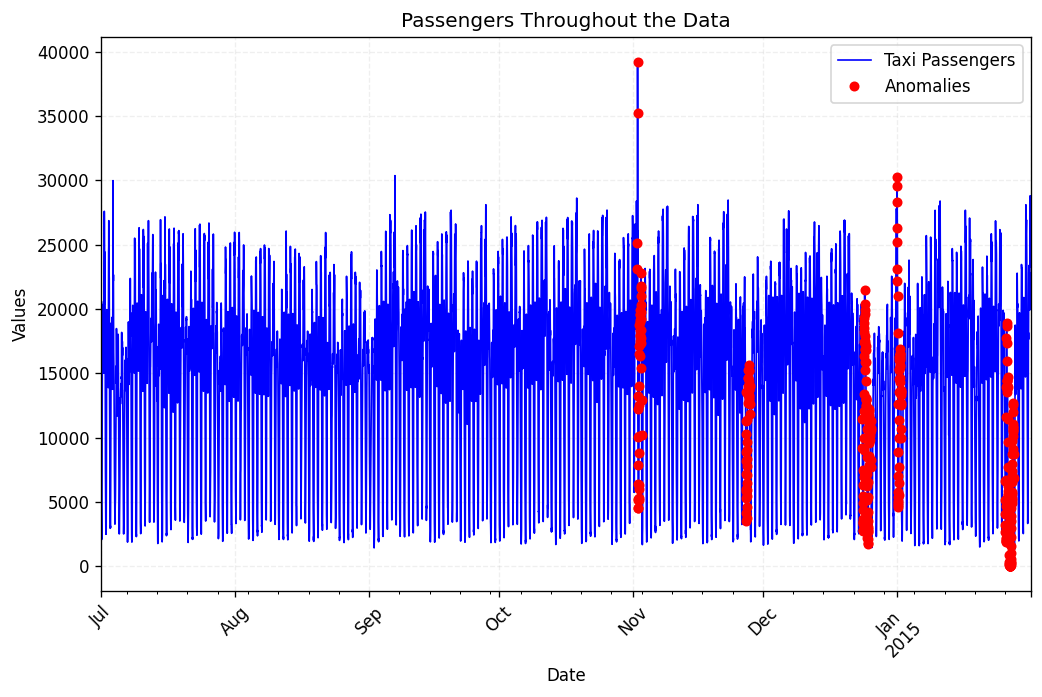

In [829]:
def make_graph(interval=None, col = 'value'):
    # Plotting the main "value" series
    if interval is None:
        graph = dataset[col]
        anomaly = dataset.loc[dataset['isAnomaly'], col]
        title = 'Passengers Throughout the Data'
    else:
        start, end = interval  # Unpack the start and end dates
        graph = dataset.loc[start:end, col]
        anomaly = dataset.loc[
            (dataset.index >= start) & (dataset.index <= end) & (dataset['isAnomaly']),
            'value'
        ]
        title = f'Passengers from {start} to {end}'

    # Plot the main graph
    graph.plot(figsize=(10, 6), color='blue', linewidth=1, label='Taxi Passengers')

    # Plot anomalies if they exist
    if not anomaly.empty:
        anomaly.plot(
            linestyle='None',
            marker='o',
            color='red',
            markersize=5,
            label='Anomalies'
        )

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)

    # Rotating x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adding a grid with some transparency
    plt.grid(True, linestyle='--', alpha=0.2)

    # Displaying the legend to differentiate the series
    plt.legend()

    # Show the plot
    plt.show()

# Throughout the data
make_graph()

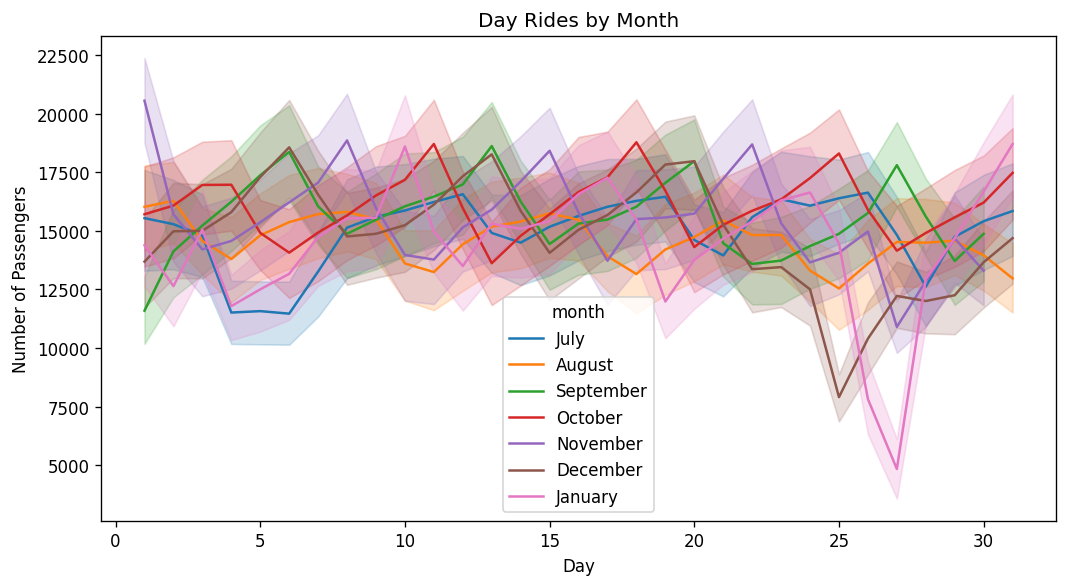

In [830]:
# By each months for every hours
sns.lineplot(
    x="day", 
    y="value",
    data=dataset,
    hue= "month")
plt.xlabel("Day")
plt.ylabel("Number of Passengers")
plt.title("Day Rides by Month")
plt.tight_layout()
plt.show()

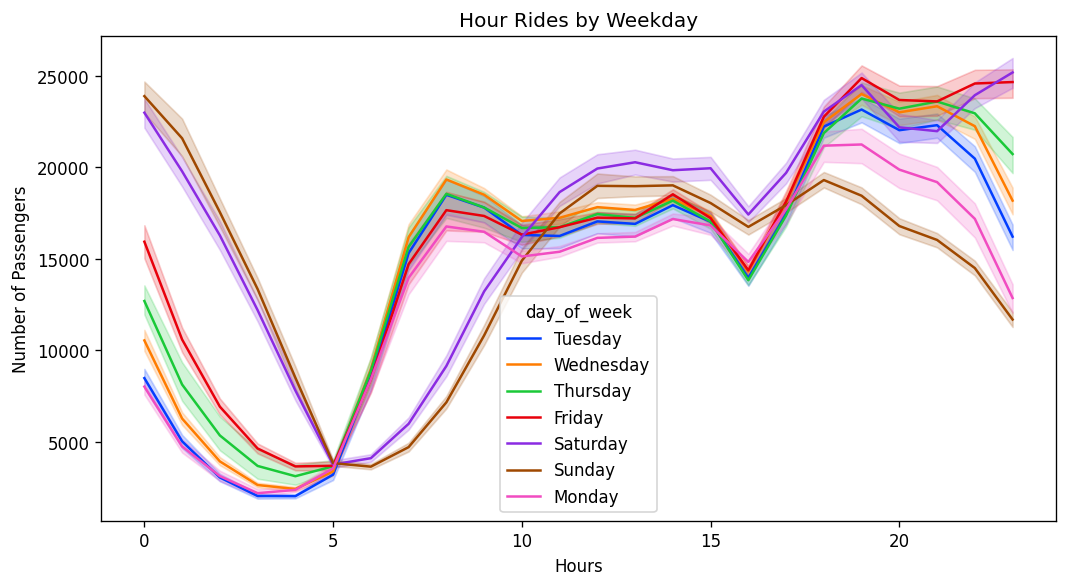

In [831]:
sns.lineplot(
    x="hour", 
    y="value",
    data=dataset,
    palette='bright',
    hue= "day_of_week")
plt.xlabel("Hours")
plt.ylabel("Number of Passengers")
plt.title("Hour Rides by Weekday")
plt.tight_layout()
plt.show()

### Variables prep & snow & snow_depth

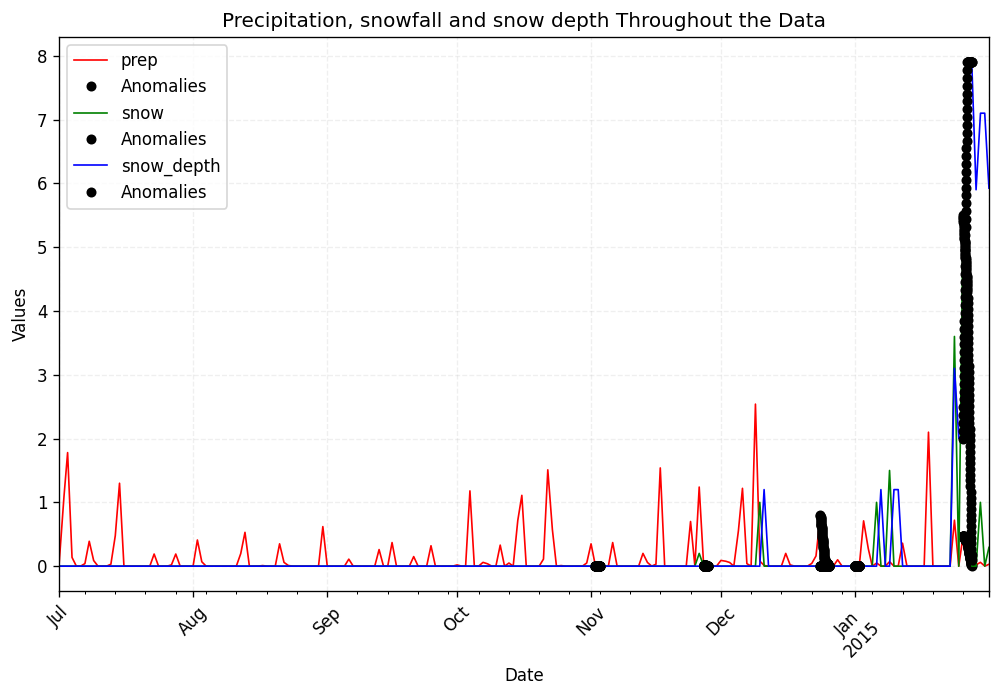

In [832]:
col_to_check = ['prep','snow','snow_depth']
graph = dataset[col_to_check]
anomaly = dataset.loc[dataset['isAnomaly'], col_to_check]
title = 'Precipitation, snowfall and snow depth Throughout the Data'
# Plot the main graph
colour = ['red','green','blue']
for ind in range(len(col_to_check)):
    graph[col_to_check[ind]].plot(figsize=(10, 6), color=colour[ind], linewidth=1, label=col_to_check[ind])
    anomaly[col_to_check[ind]].plot(linestyle='None',marker='o',color='black',markersize=5,label='Anomalies')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(title)

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding a grid with some transparency
plt.grid(True, linestyle='--', alpha=0.2)

# Displaying the legend to differentiate the series
plt.legend()

# Show the plot
plt.show()

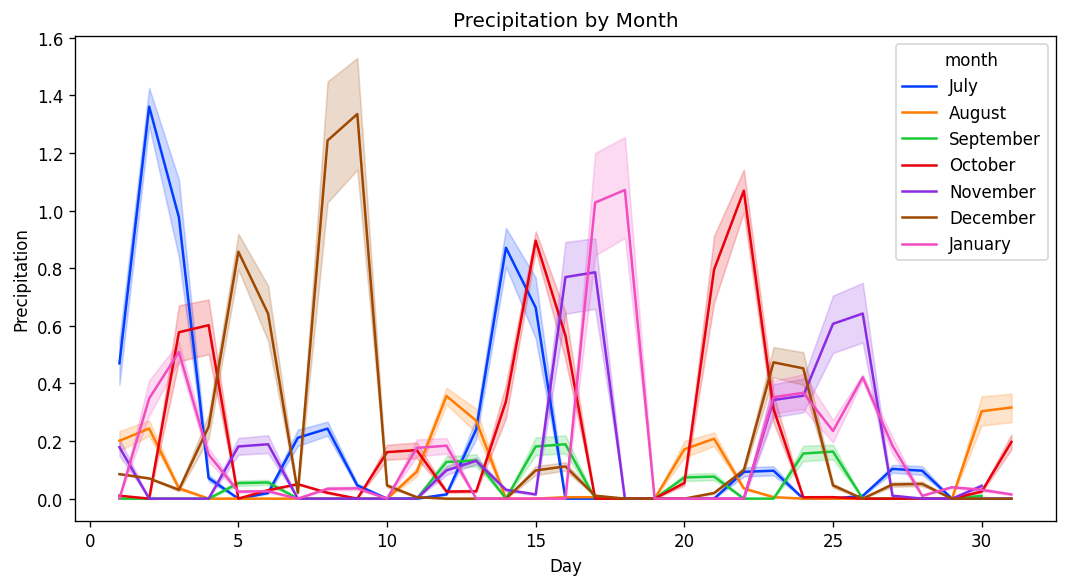

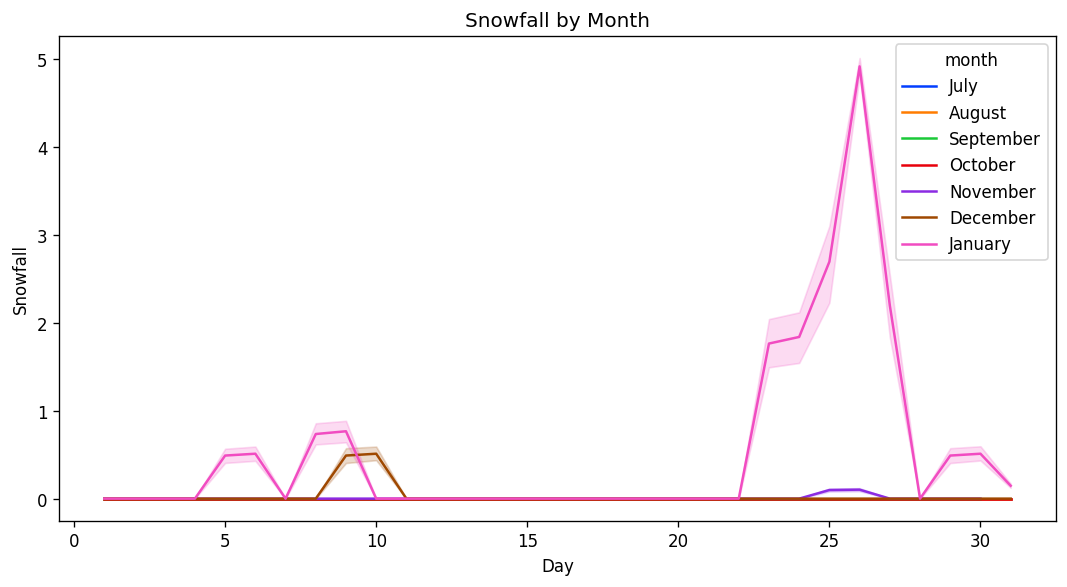

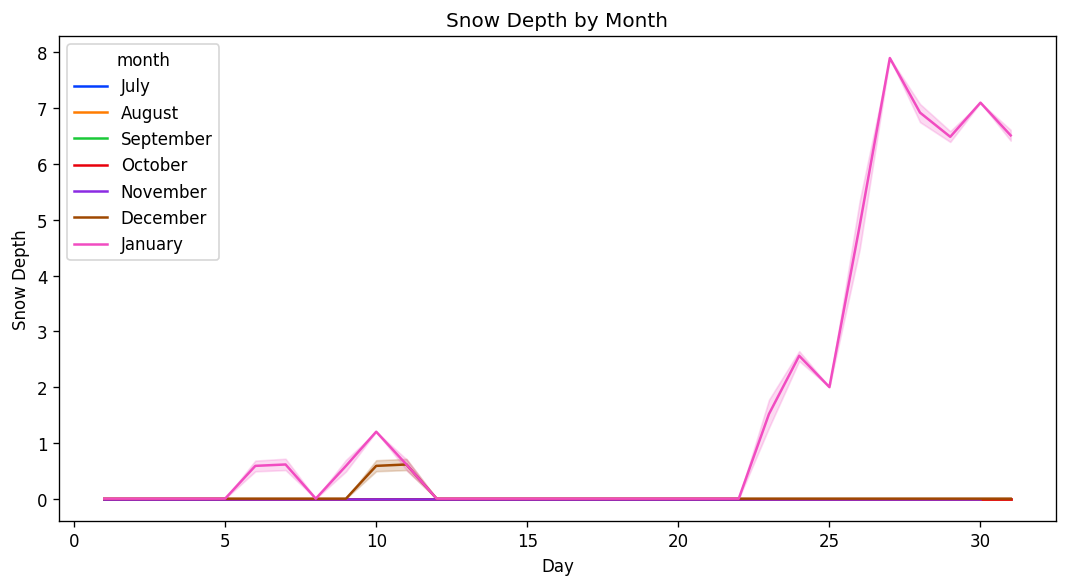

In [833]:
# By each months for every hours
title = ["Precipitation", "Snowfall", "Snow Depth"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "month")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Month")
    plt.tight_layout()
    plt.show()

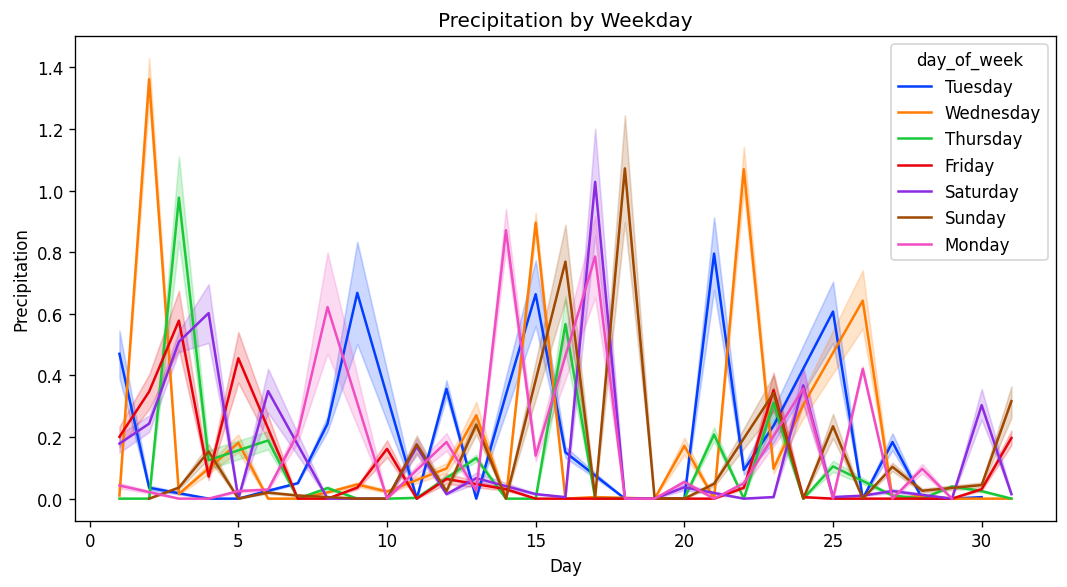

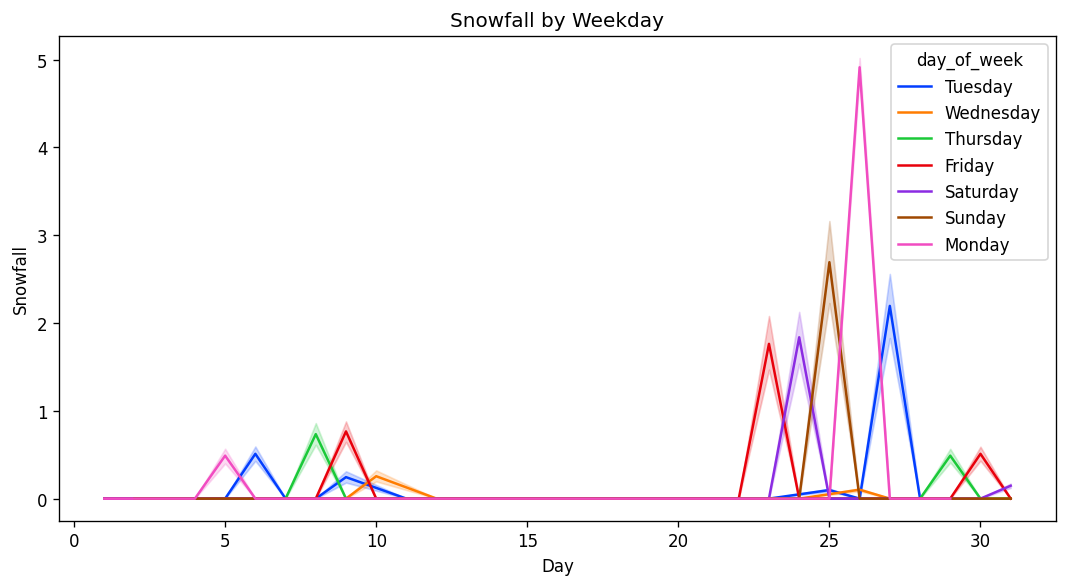

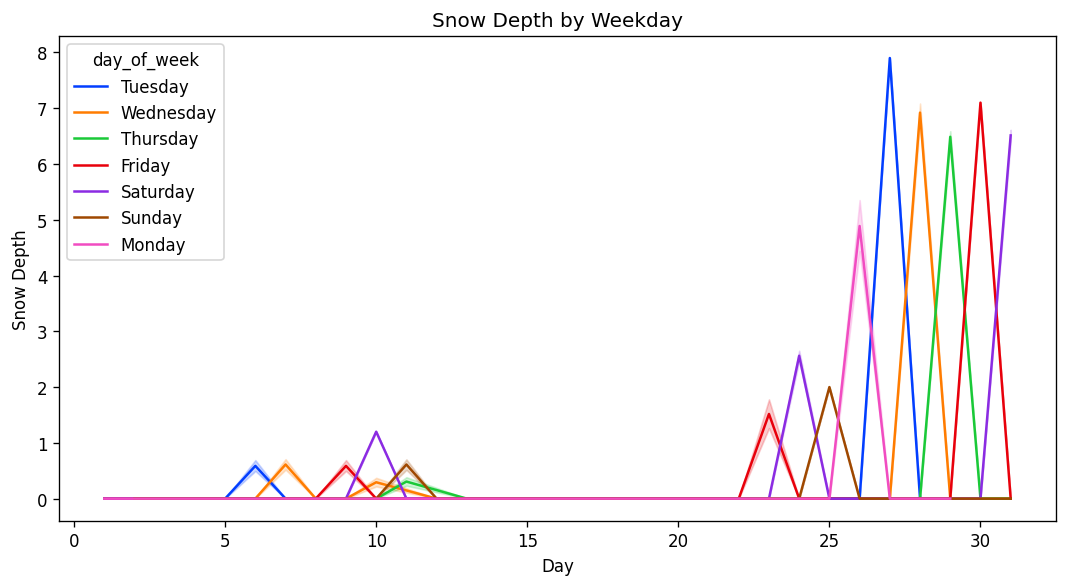

In [834]:
# By each day_of_week
title = ["Precipitation", "Snowfall", "Snow Depth"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "day_of_week")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Weekday")
    plt.tight_layout()
    plt.show()

### Variables min_temp, max_temp, range_temp

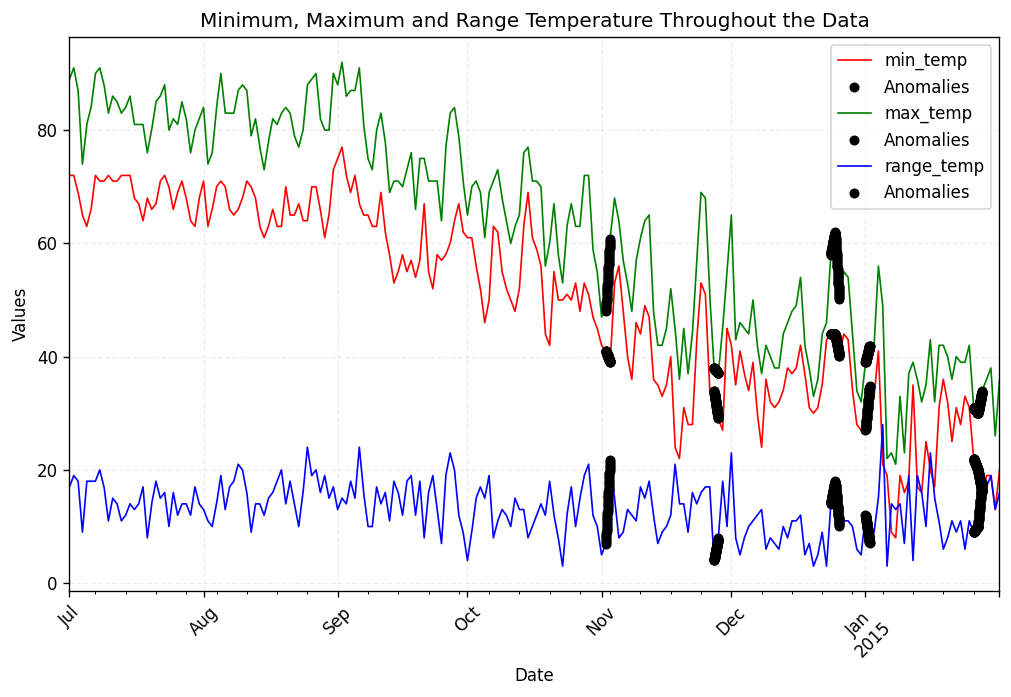

In [835]:
col_to_check = ['min_temp','max_temp','range_temp']
graph = dataset[col_to_check]
anomaly = dataset.loc[dataset['isAnomaly'], col_to_check]
title = 'Minimum, Maximum and Range Temperature Throughout the Data'
# Plot the main graph
colour = ['red','green','blue']
for ind in range(len(col_to_check)):
    graph[col_to_check[ind]].plot(figsize=(10, 6), color=colour[ind], linewidth=1, label=col_to_check[ind])
    anomaly[col_to_check[ind]].plot(linestyle='None',marker='o',color='black',markersize=5,label='Anomalies')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(title)

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding a grid with some transparency
plt.grid(True, linestyle='--', alpha=0.2)

# Displaying the legend to differentiate the series
plt.legend()

# Show the plot
plt.show()

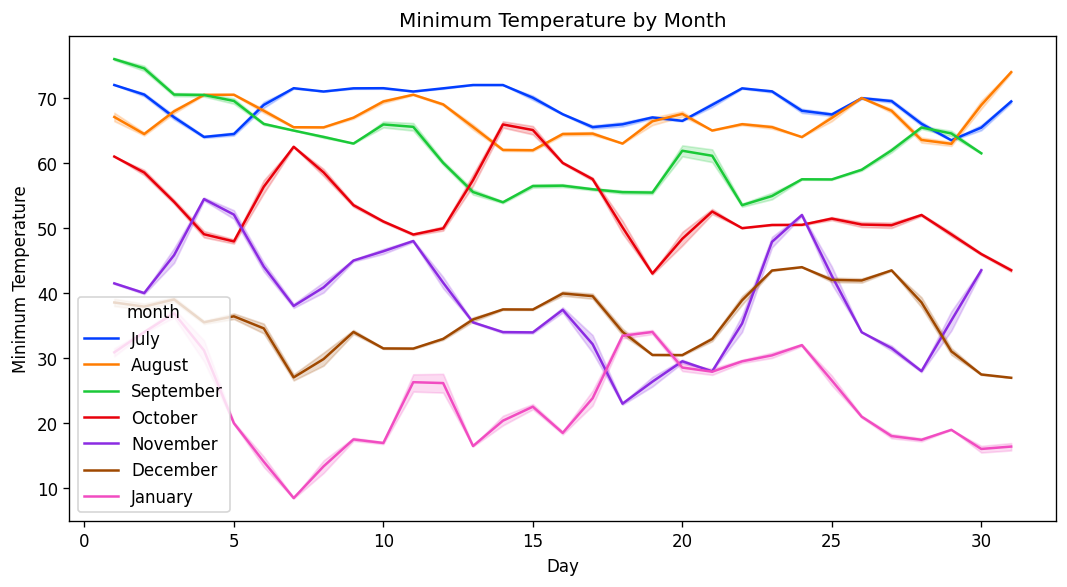

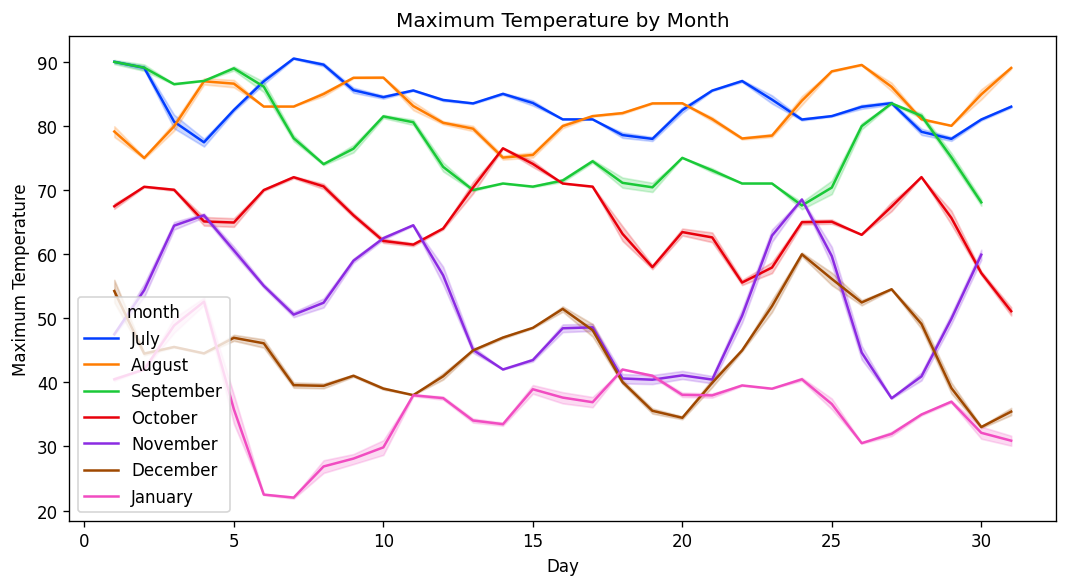

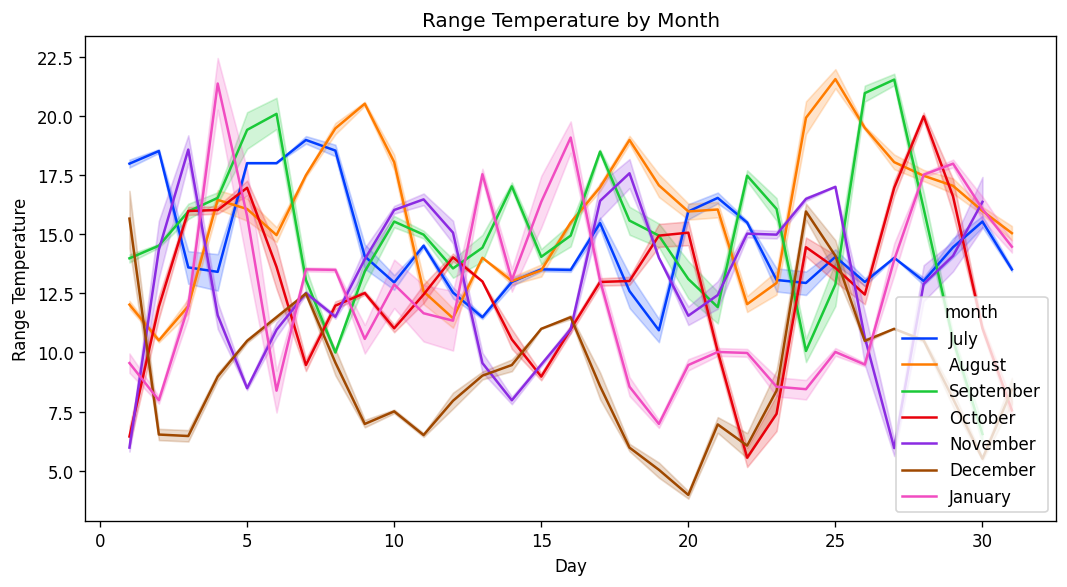

In [836]:
# By each months for every hours
title = ["Minimum Temperature", "Maximum Temperature", "Range Temperature"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "month")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Month")
    plt.tight_layout()
    plt.show()

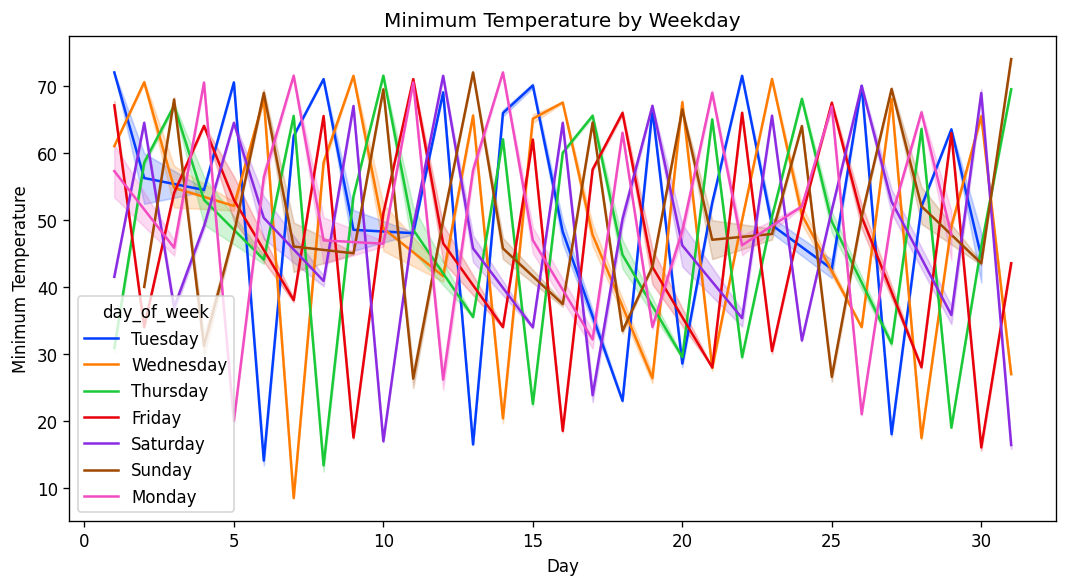

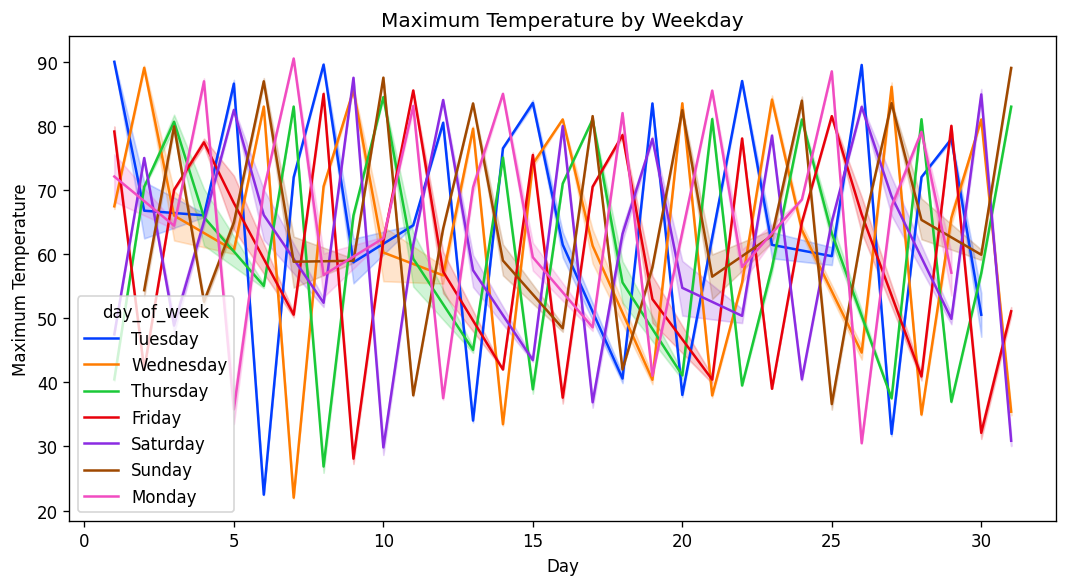

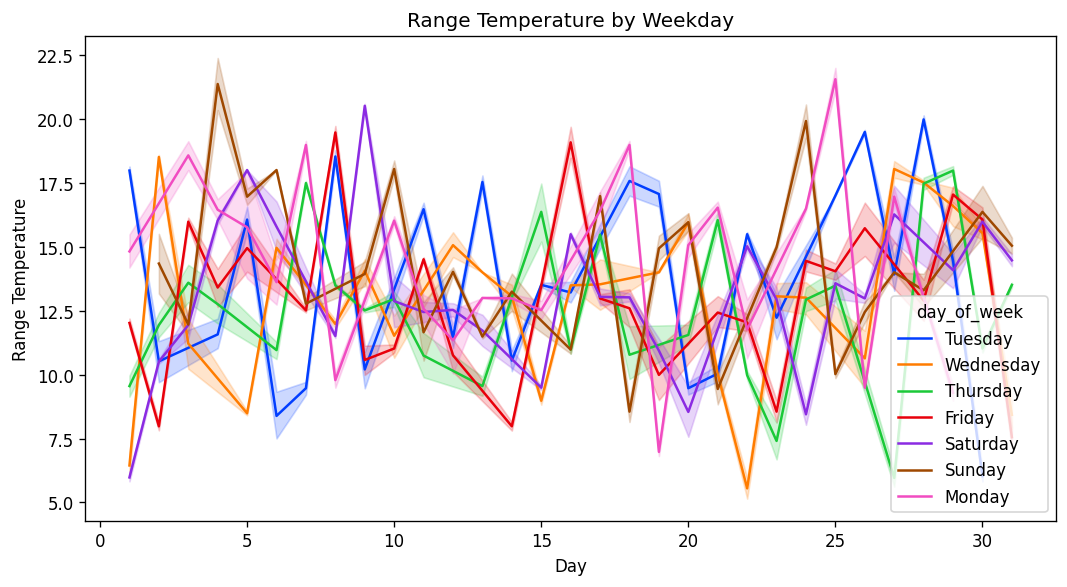

In [837]:
# By each day_of_week
title = ["Minimum Temperature", "Maximum Temperature", "Range Temperature"]
for ind in range(len(col_to_check)):
    sns.lineplot(
        x="day", 
        y=col_to_check[ind],
        data=dataset,
        palette='bright',
        hue= "day_of_week")
    plt.xlabel("Day")
    plt.ylabel(title[ind])
    plt.title(f"{title[ind]} by Weekday")
    plt.tight_layout()
    plt.show()

## 3 consecutive normal and anomalous weeks

There are two detections that makes the dates are in anomaly
- The values in at least 1 data entry among the specified date range is over or under limits
- Not following usual patterns for the last 7 - 14 days

Specified problems with each anomalous date:
- 2 November 2014 (Annual Marathon): Limits
- 27 November 2014 (Thanksgiving): Wrong Patterns
- 24 & 25 December 2014 (Chritsmas): Wrong Patterns
- 1 January 2015 (New Years): Limits
- 26 & 27 January 2015 (Snowstorm): Limits & Wrong Patterns

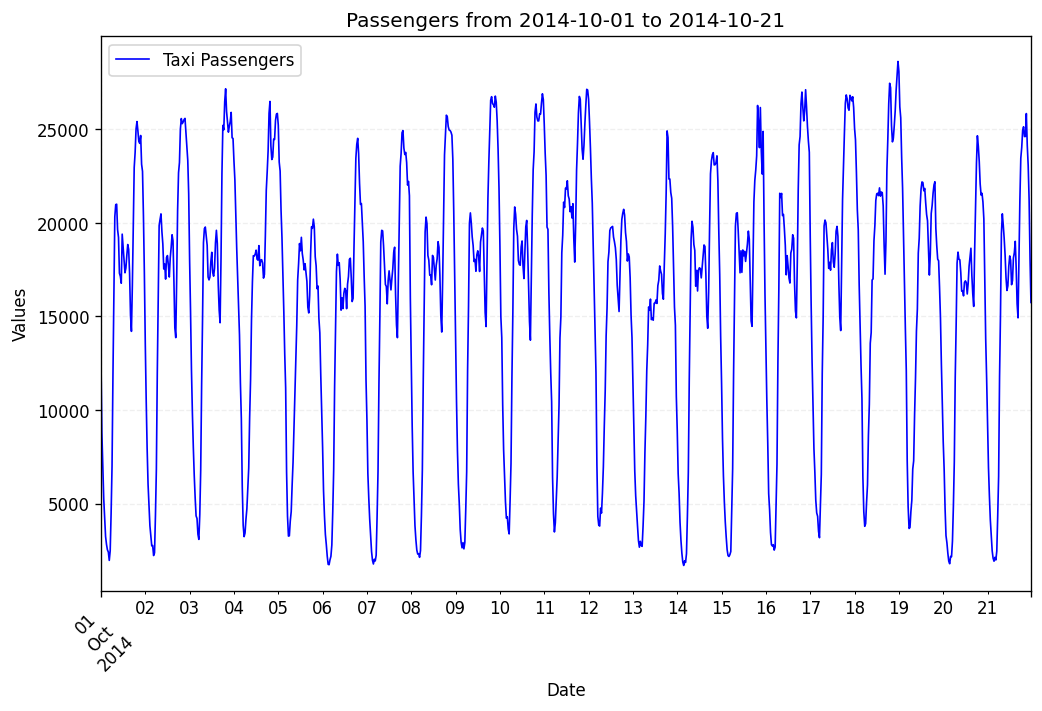

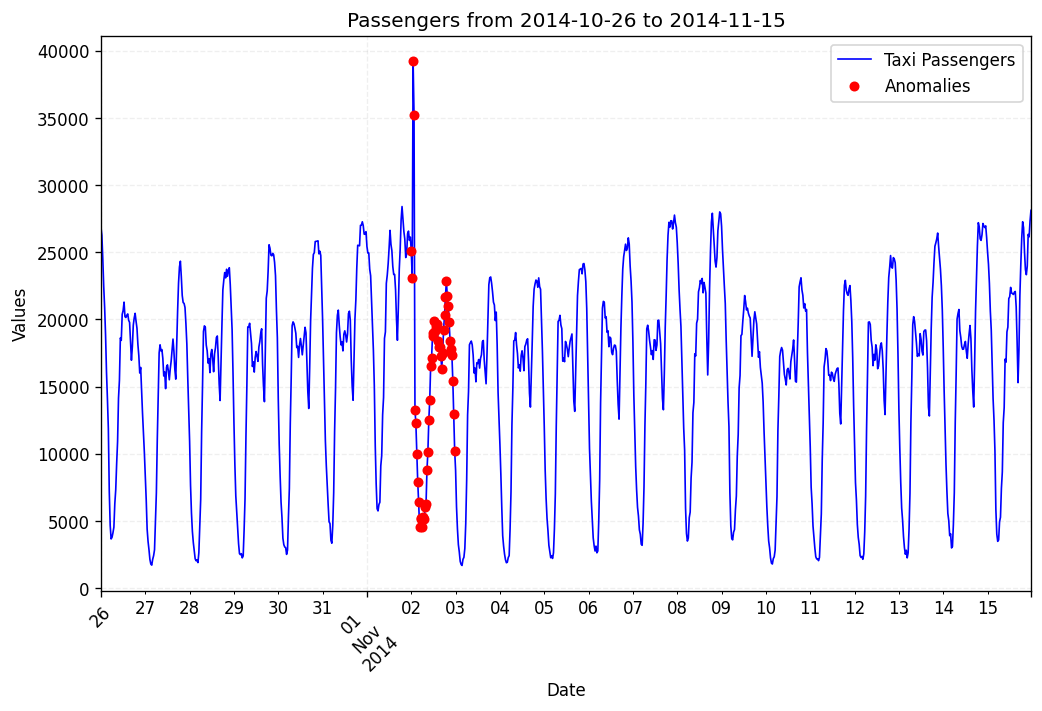

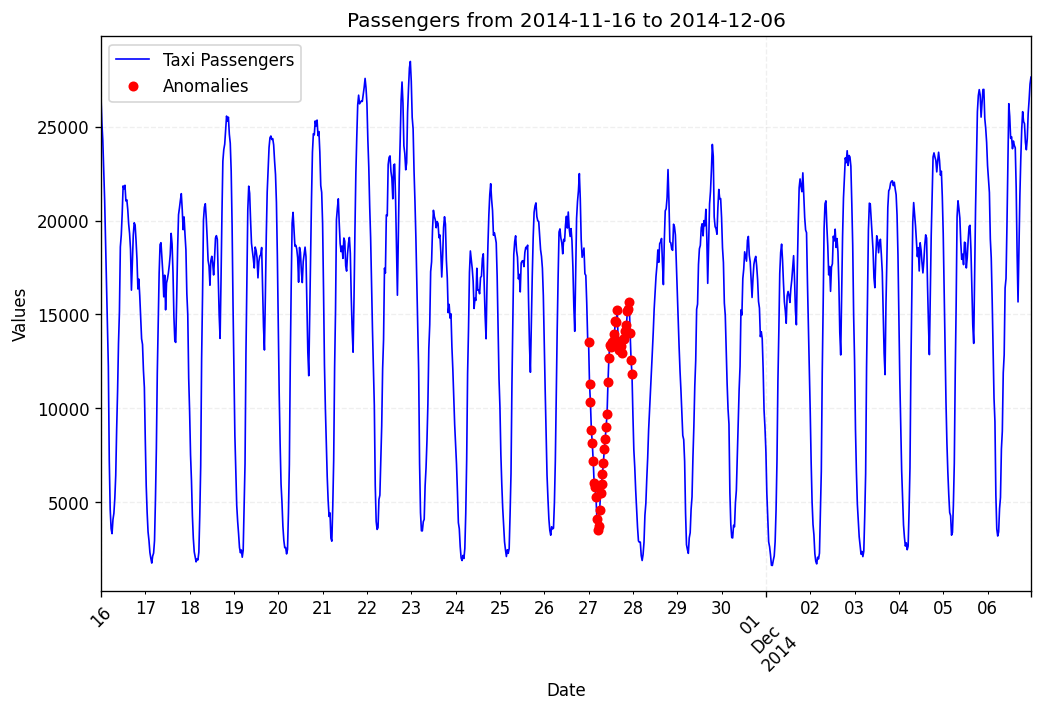

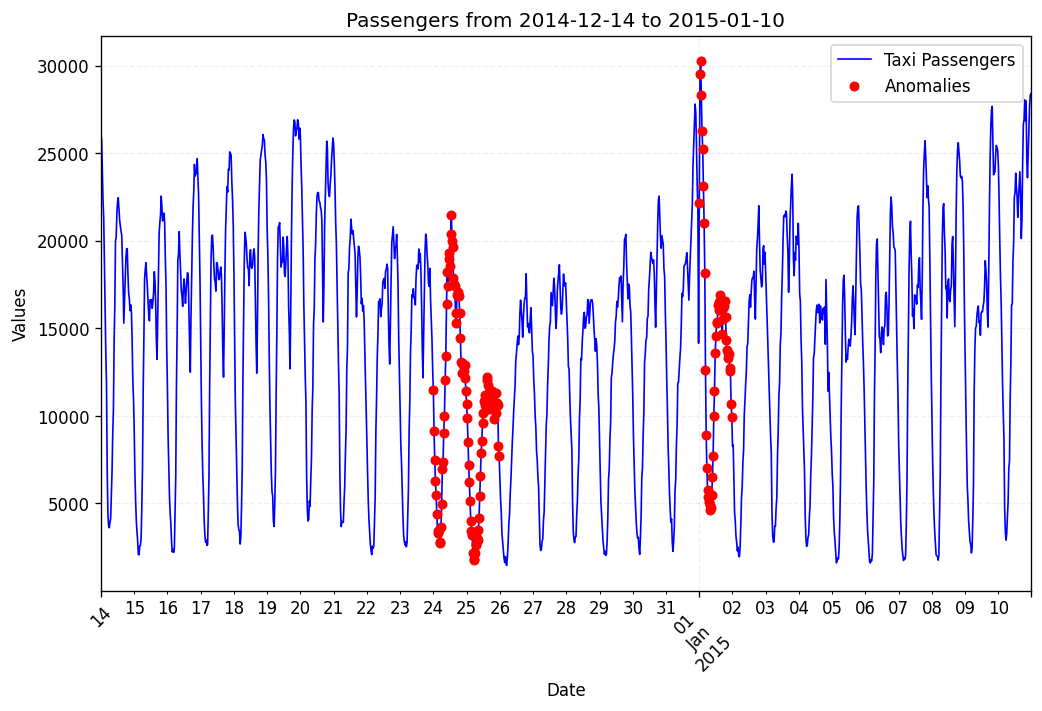

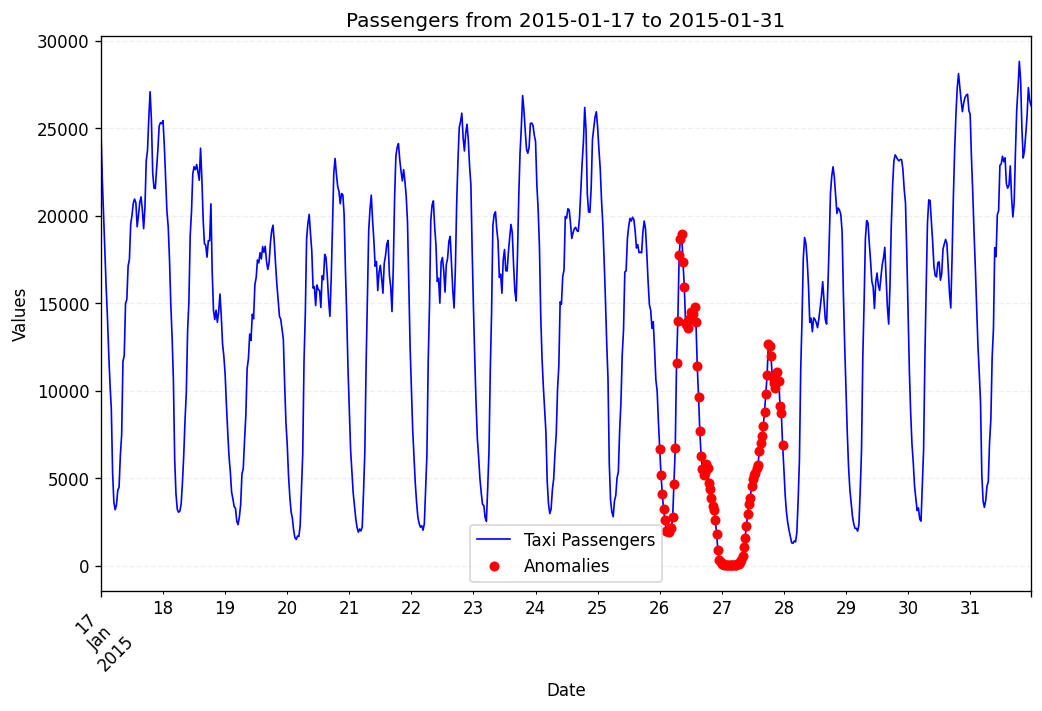

In [838]:
consicutive_weeks = [ 
        ['2014-10-01','2014-10-21'], # Normal
        ['2014-10-26','2014-11-15'], # Annual Marathon
        ['2014-11-16','2014-12-06'], # Thanksgiving
        ['2014-12-14','2015-01-10'], # Christmas and New Years
        ['2015-01-17','2015-01-31'] # Snowstorm
    ]
# Iterate over anomaly periods and plot
for interval in consicutive_weeks:
    make_graph(interval)

## Normal distribution checking

"value" feature are not in normal distribution

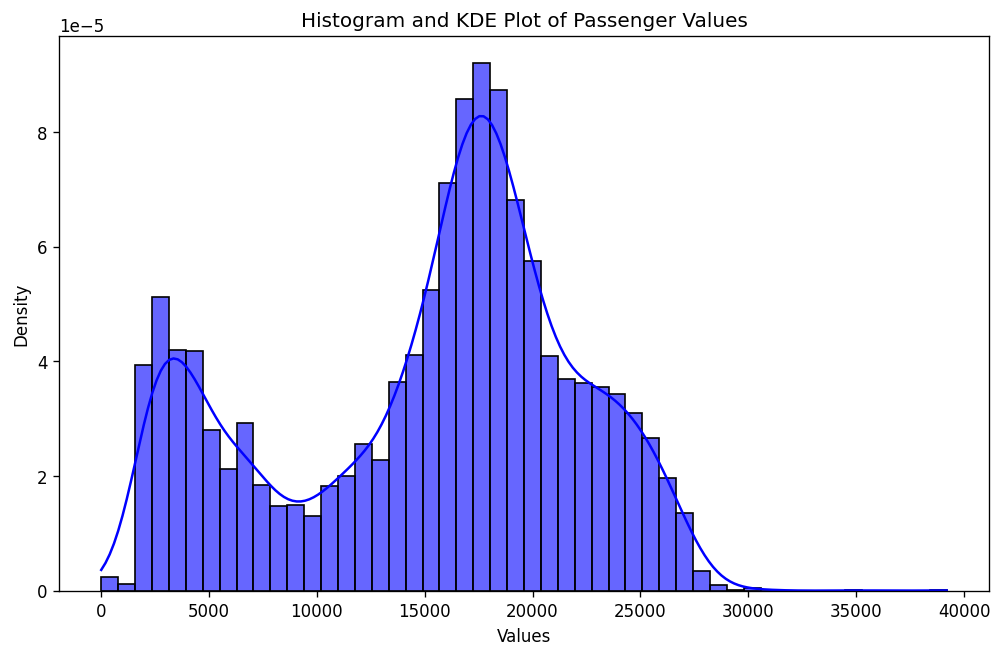

In [839]:
# Plot histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(dataset['value'], kde=True, bins=50, color='blue', stat='density', alpha=0.6)
plt.title('Histogram and KDE Plot of Passenger Values')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

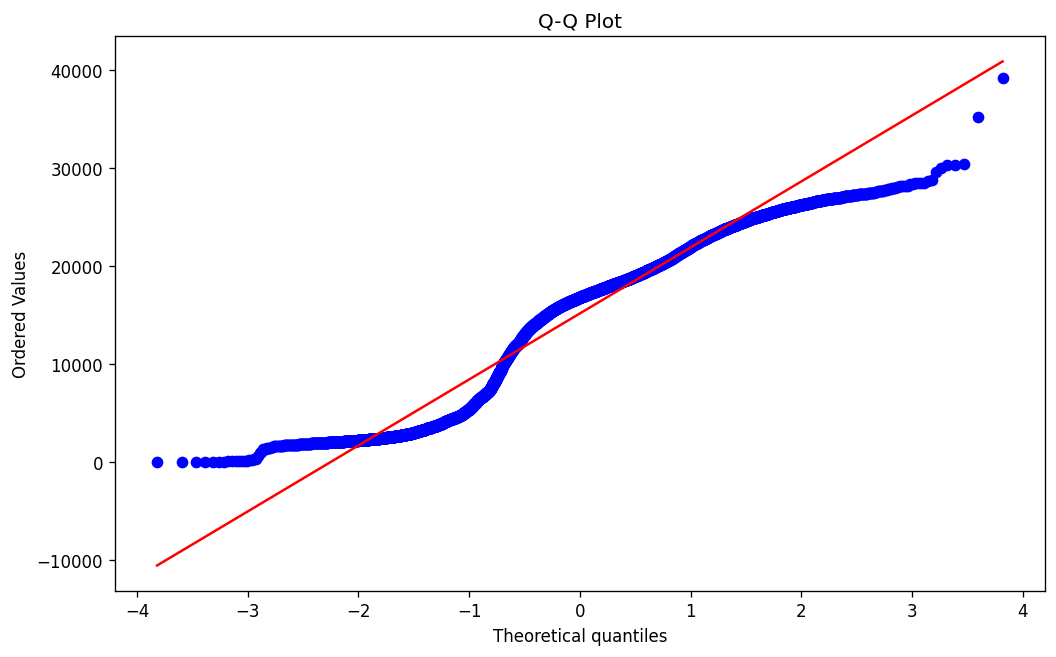

In [840]:
import scipy.stats as stats

# Generate Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(dataset['value'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


## Lag Plots

value feature has autocorrelation in the series

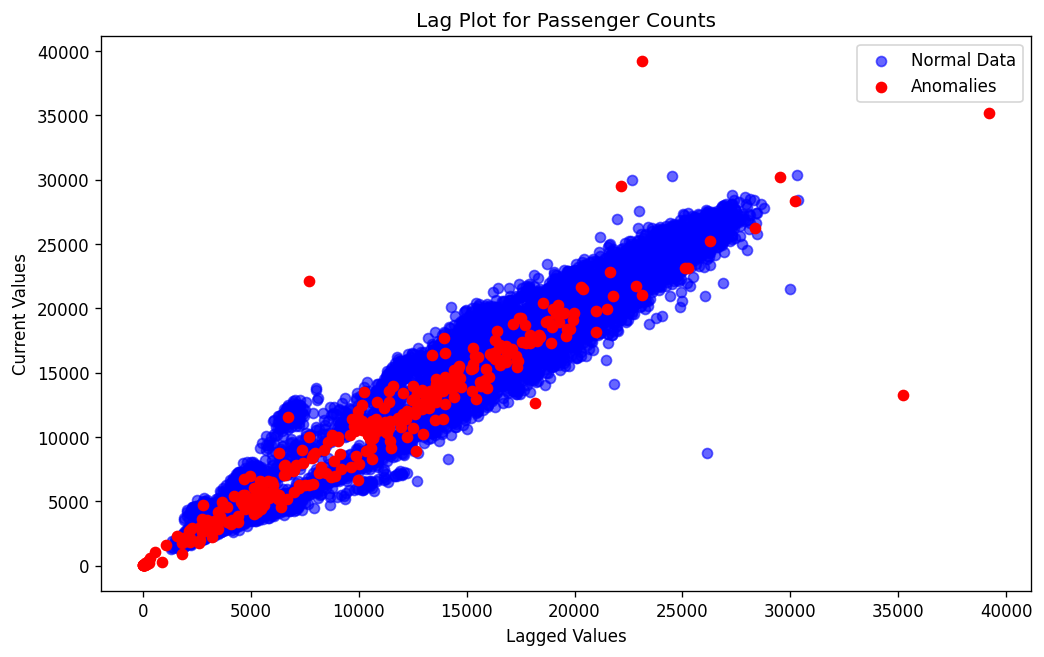

In [841]:
# Separate normal and anomaly data
normal_data = dataset[~dataset['isAnomaly']]  # Data without anomalies
anomaly_data = dataset[dataset['isAnomaly']]  # Data with anomalies

# Create lag plot
plt.figure(figsize=(10, 6))

# Plot normal data
plt.scatter(
    normal_data['value'][:-1],  # Lagging 'value'
    normal_data['value'][1:],   # Current 'value'
    color='blue', alpha=0.6, label='Normal Data'
)

# Plot anomaly data
plt.scatter(
    anomaly_data['value'][:-1],  # Lagging 'value'
    anomaly_data['value'][1:],   # Current 'value'
    color='red', label='Anomalies'
)

# Add plot title and legend
plt.title('Lag Plot for Passenger Counts')
plt.xlabel('Lagged Values')
plt.ylabel('Current Values')
plt.legend()

# Show the plot
plt.show()


## Seasonality and Trends

- Observed:
    - The original dataset
- Trends:
    - reflects the long-term movement in the data
    - shows the underlying increase or decrease in passenger counts over time.
    - Our data shows the repeated patterns - weekly trends
- Seasonal:
    - captures the repeated patterns or cycles in the data (e.g., daily, weekly, or monthly seasonality)
    - Can support the autocorrelation idea
    - Our data shows the cyclic behaviour due to its consistency on patterns for certain times
- Residual:
    - the "leftover" or irregular component after removing the trend and seasonal components
    - represents noise or unexplained variation in the data
    - 2 anomalous dates detected due to the sudden spikes

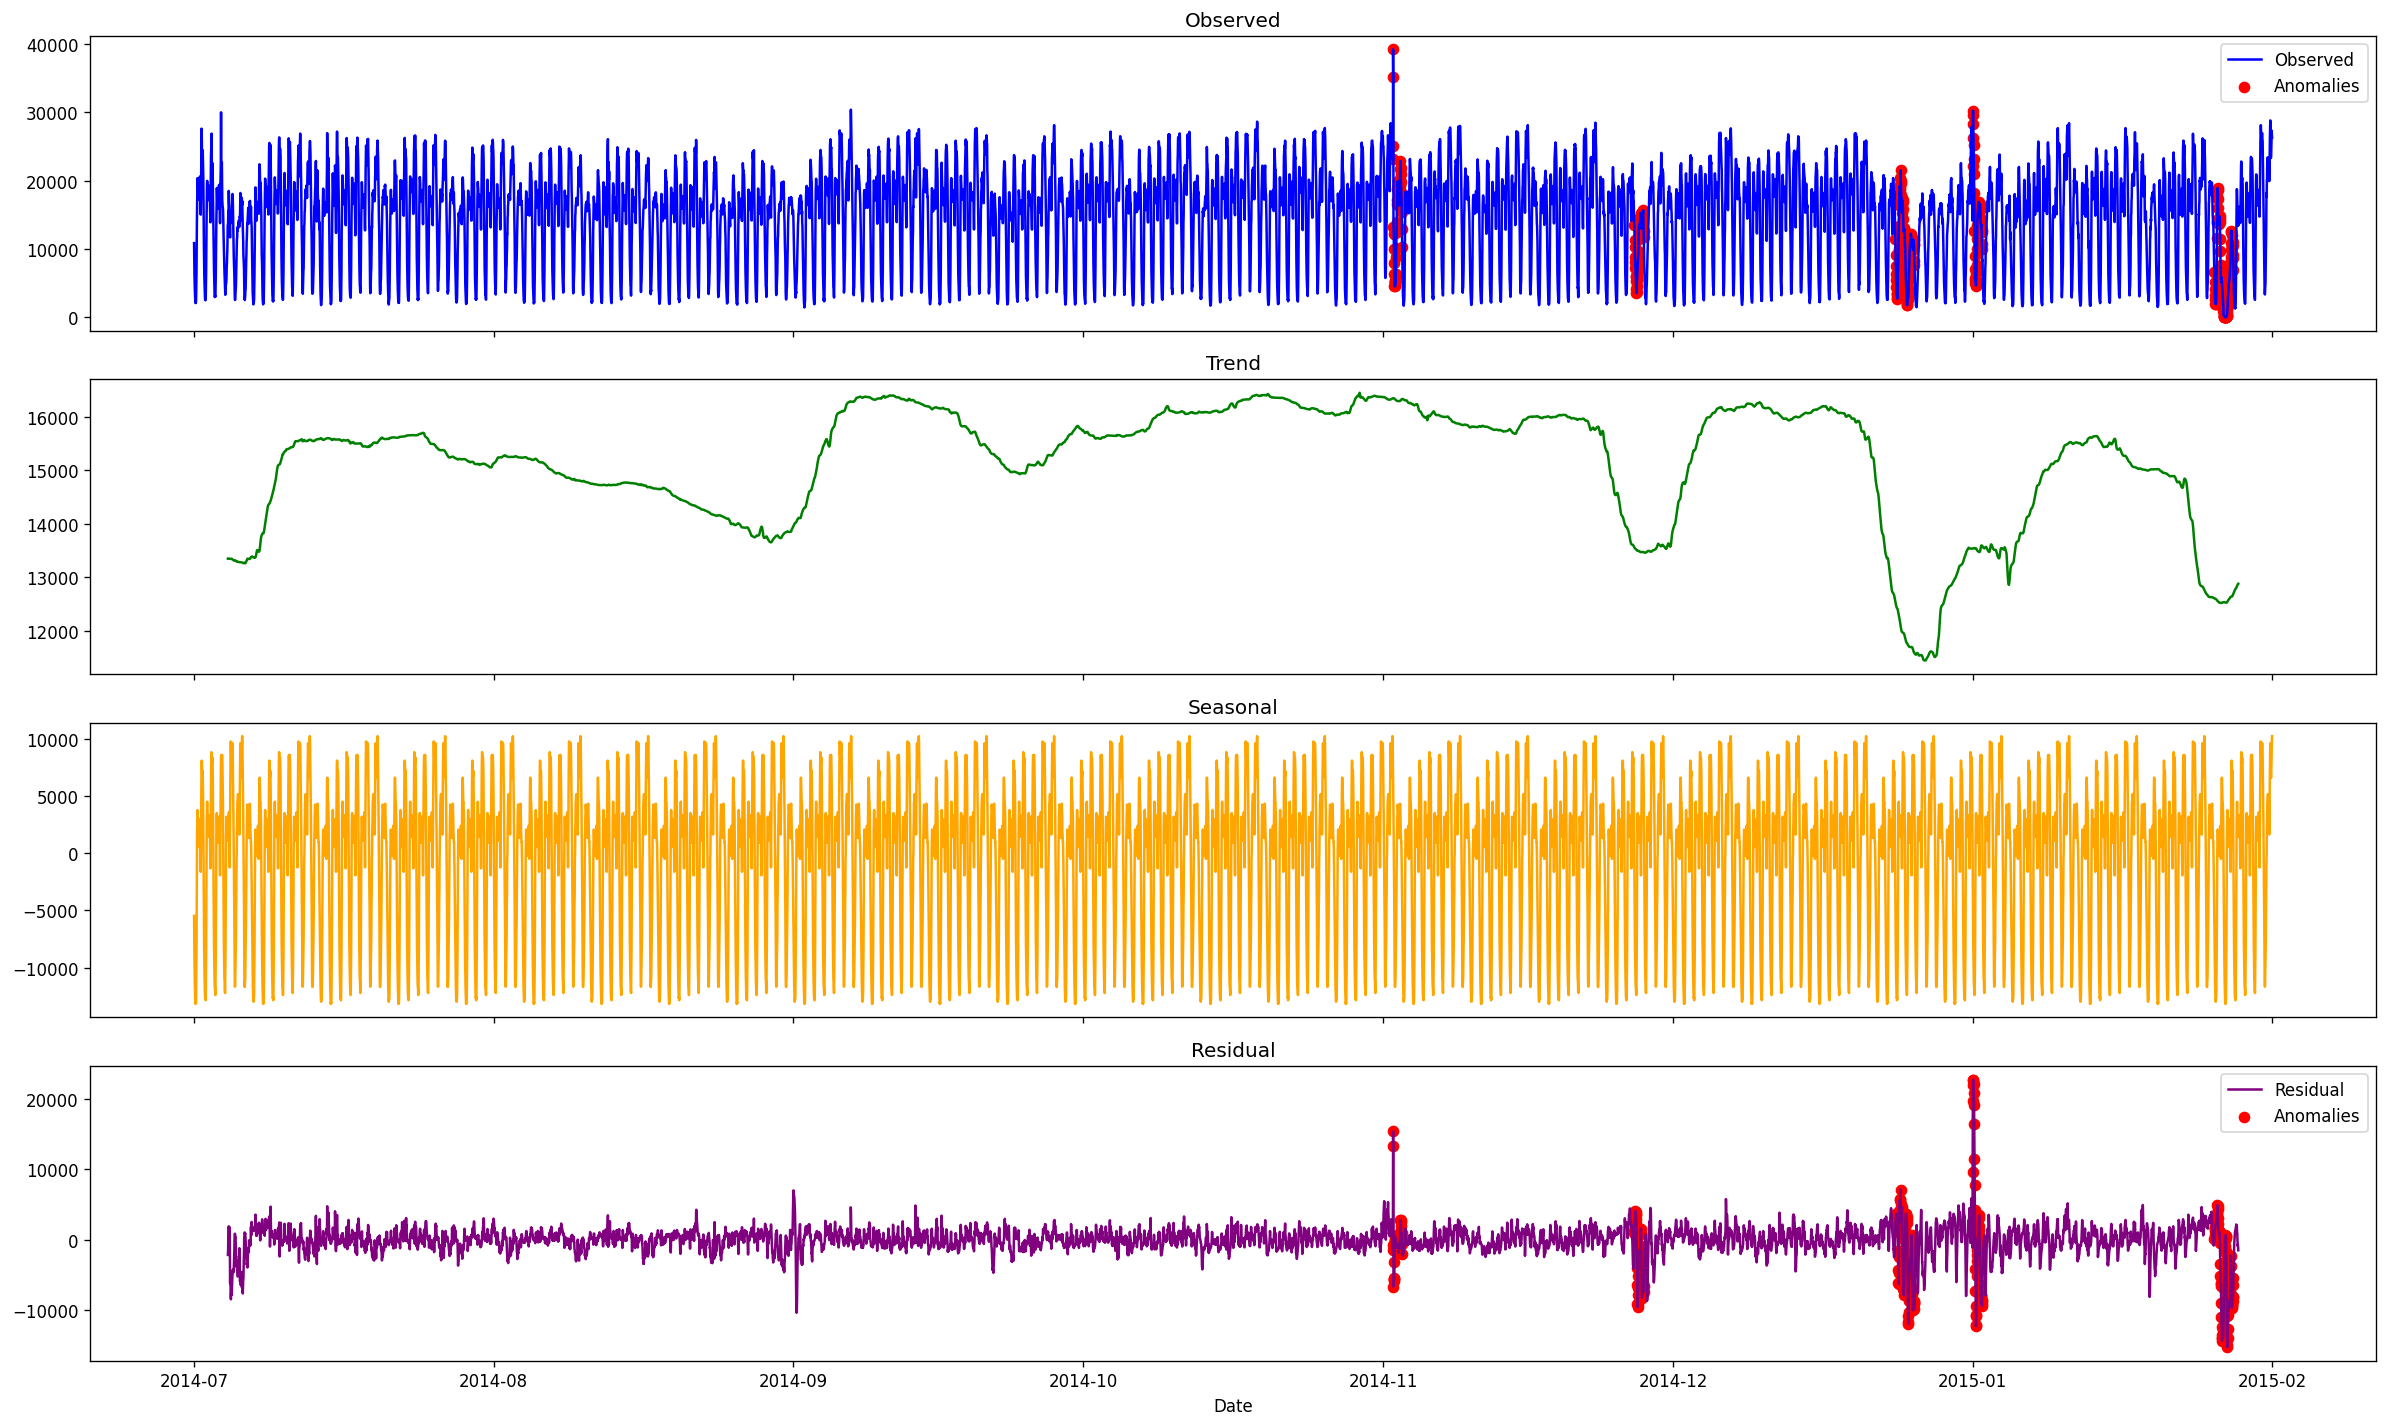

In [853]:
# Decompose the time series
decompose_result = seasonal_decompose(dataset['value'], model='additive', period=336)

# Extract components
observed = decompose_result.observed
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

# Anomalies: Get index of anomalies
anomaly_indices = dataset.loc[dataset['isAnomaly']].index

# Plot decomposed components with anomaly highlights
fig, axes = plt.subplots(4, 1, figsize=(20, 12), sharex=True)

# Observed
axes[0].plot(observed, label='Observed', color='blue')
axes[0].scatter(anomaly_indices, observed.loc[anomaly_indices], color='red', label='Anomalies')
axes[0].set_title('Observed')
axes[0].legend()

# Trend
axes[1].plot(trend, label='Trend', color='green')
axes[1].set_title('Trend')

# Seasonal
axes[2].plot(seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal')

# Residual
axes[3].plot(residual, label='Residual', color='purple')
axes[3].scatter(anomaly_indices, residual.loc[anomaly_indices], color='red', label='Anomalies')
axes[3].set_title('Residual')
axes[3].legend()

# Formatting
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [854]:
adf_test = adfuller(residual.dropna())
print(f"Residual Stationarity Test p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The Residual is Stationary")
else:
    print("The Residual is non-stationary")


Residual Stationarity Test p-value: 5.55180050368637e-21
The Residual is Stationary


## Stationary Properties

- From ADF test,
    - the value feature is stationary
    - the isAnomaly feature is stationary

- From KPSS test,
    - the value feature is trend-stationary
    - the isAnomaly feature is non-trend-stationary

In [855]:
# ADF Test
print("ADF Test")
print("Using on value")
result = adfuller(dataset['value'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
print("\n")
print("Using on isAnomaly")
result = adfuller(dataset['isAnomaly'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Test
Using on value
ADF Statistic: -10.764517454017037
p-value: 2.4721317220666687e-19
Critial Values:
   1%, -3.4309862775905664
Critial Values:
   5%, -2.8618211976893573
Critial Values:
   10%, -2.566919676386092


Using on isAnomaly
ADF Statistic: -8.942148235384224
p-value: 9.191722701586968e-15
Critical Values:
   1%, -3.4309838722215322
Critical Values:
   5%, -2.8618201347695615
Critical Values:
   10%, -2.566919110593691


In [856]:
# KPSS Test
print("KPSS Test")
print("Using on value")
result = kpss(dataset['value'], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
print("Using on isAnomaly")
result = kpss(dataset['isAnomaly'], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

KPSS Test
Using on value

KPSS Statistic: 0.418064
p-value: 0.069369
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
Using on isAnomaly

KPSS Statistic: 1.079606
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


C:\Users\weare\AppData\Local\Temp\ipykernel_12792\2800864707.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(dataset['isAnomaly'], regression='c')


## Correlation, Full and Partial Autocorrelation

- In Spearman Correlation, 
    - value is correlated with: 
        - hour (0.63)
        - isAnomaly (-0.13)
    - isAnomaly is correlated with:
        - Holiday and isHoliday (0.35 each)
        - month (0.20)
        - max_temp and min_temp (-0.18 each)
        - snow and snow_depth (0.16 each)
        - value (-0.13)
    - Other features are close to 0
    
- In Autocorrelation,
    - Find correlation between current val to all of the previous values in the series based on lags
    - At early lags (0 - 50): Values is very high - strongly correlated
    - At 1 week lag (336): 0.86 - Strongly correlated
    - As increased by 1 week: stay in range of 0.7 to 0.9

- In Partial Autocorrelation,
    - Find correlation between current val to ONLY the lagged value
    - At early lags (0 - 5 approx): Values is very high - strongly correlated
    - As increase: getting smaller to closer to 0


In [857]:
# Create a copy of the dataset
temporary = dataset.copy()

# Select features for correlation (ensure valid column names)
features = temporary.columns

# Convert categorical columns to numeric using factorize
temporary['month'] = pd.factorize(temporary['month'])[0]
temporary['day_of_week'] = pd.factorize(temporary['day_of_week'])[0]
temporary['Holiday'] = pd.factorize(temporary['Holiday'])[0]

# Initialize an empty dataframe to store results
corr_df = pd.DataFrame(columns=["Target", "Feature", "Spearman Correlation", "p_value", "less than 0.05?"])

# Iterate over each target and feature to calculate Spearman correlation
for target in ['value', 'isAnomaly']:
    for feature in features:
        corr, p_value = spearmanr(temporary[target], temporary[feature])
        
        # Append the results to the DataFrame
        corr_df.loc[len(corr_df)] = {
            "Target": target,
            "Feature": feature,
            "Spearman Correlation": corr,
            "p_value": p_value,
            "less than 0.05?": p_value < 0.05
        }

# Display the result DataFrame
corr_df


Target      Feature  Spearman Correlation        p_value  \
0       value        value              1.000000   0.000000e+00   
1       value        month             -0.002907   7.677597e-01   
2       value          day             -0.051722   1.462888e-07   
3       value         hour              0.628512   0.000000e+00   
4       value  day_of_week             -0.039356   6.356986e-05   
5       value    isWeekend              0.064605   5.060914e-11   
6       value    isAnomaly             -0.126685   3.464635e-38   
7       value      Holiday             -0.104937   1.151823e-26   
8       value         prep             -0.012610   2.002346e-01   
9       value         snow             -0.036948   1.738213e-04   
10      value   snow_depth             -0.021059   3.241293e-02   
11      value     min_temp             -0.016399   9.574502e-02   
12      value     max_temp             -0.024433   1.305922e-02   
13      value    isHoliday             -0.104834   1.290643e-26   
14      value   range_temp             -0.050683   2.585309e-07   
15  isAnomaly        value             -0.126685   3.464635e-38   
16  isAnomaly        month              0.195823   9.876127e-90   
17  isAnomaly          day              0.062104   2.714394e-10   
18  isAnomaly         hour              0.000000   1.000000e+00   
19  isAnomaly  day_of_week             -0.037543   1.362783e-04   
20  isAnomaly    isWeekend             -0.057323   5.629954e-09   
21  isAnomaly    isAnomaly              1.000000   0.000000e+00   
22  isAnomaly      Holiday              0.361427   0.000000e+00   
23  isAnomaly         prep              0.059408   1.544031e-09   
24  isAnomaly         snow              0.159356   1.147125e-59   
25  isAnomaly   snow_depth              0.157932   1.264481e-58   
26  isAnomaly     min_temp             -0.178095   2.673521e-74   
27  isAnomaly     max_temp             -0.182427   6.314140e-78   
28  isAnomaly    isHoliday              0.354232  8.618056e-303   
29  isAnomaly   range_temp             -0.057561   4.868493e-09   

    less than 0.05?  
0              True  
1             False  
2              True  
3              True  
4              True  
5              True  
6              True  
7              True  
8             False  
9              True  
10             True  
11            False  
12             True  
13             True  
14             True  
15             True  
16             True  
17             True  
18            False  
19             True  
20             True  
21             True  
22             True  
23             True  
24             True  
25             True  
26             True  
27             True  
28             True  
29             True

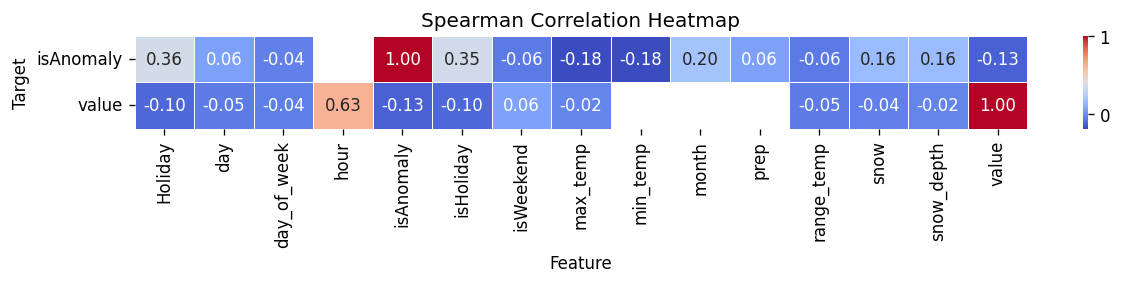

In [858]:
# Pivot the DataFrame to create a matrix of Spearman Correlations
corr_df = corr_df.loc[corr_df['less than 0.05?']]
heatmap_data = corr_df.pivot(index='Target', columns='Feature', values='Spearman Correlation')

# Create the heatmap
plt.figure(figsize=(12, 1))  # Adjust the figure size if necessary
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title and labels
plt.title('Spearman Correlation Heatmap')
plt.ylabel('Target')
plt.xlabel('Feature')

# Show the plot
plt.show()


In [ ]:
# List to store the results
autocorr_results = []

# Iterate over the lag values for both autocorrelation and partial correlation
for target in ['value', 'isAnomaly']:
    for i in range(1, 11):
        # Compute lag values in weeks (1 week = 336 half-hour periods)
        ring = i
        temporary[f'lag_{ring}_week'] = temporary['value'].shift(int(336 * ring))
        
        # Drop NaN values for valid correlation computation
        valid_data = temporary[['value', f'lag_{ring}_week']].dropna()
        
        # Autocorrelation: Spearman correlation
        if not valid_data.empty:
            autocorr_coef, autocorr_pval = spearmanr(valid_data['value'], valid_data[f'lag_{ring}_week'])
        else:
            autocorr_coef, autocorr_pval = None, None  # Handle cases with insufficient data
        
        # Partial correlation: Remove 'value' and 'lag_{ring}_week' from covar list
        covar = [feature for feature in features if feature not in ['value', f'lag_{ring}_week']]
        partial_corr_result = pg.partial_corr(data=temporary, 
                                              x='value', 
                                              y=f'lag_{ring}_week', 
                                              covar=covar, 
                                              method='spearman')
        
        # Store both autocorrelation and partial correlation results in the list
        autocorr_results.append({
            'Target': target,
            'Feature': f'lag_{ring}_week',
            'Spearman Autocorrelation': autocorr_coef,
            'Autocorr p-value': autocorr_pval,
            'Significant (Autocorr)?': autocorr_pval is not None and autocorr_pval < 0.05,
            'Spearman Partial Correlation': partial_corr_result['r'].values[0],
            'Partial Corr p-value': partial_corr_result['p-val'].values[0],
            'Significant (Partial Corr)?': partial_corr_result['p-val'].values[0] < 0.05
        })

# Create a DataFrame from the results
autocorr_results = pd.DataFrame(autocorr_results)

# Preview the results
autocorr_results


Target      Feature  Spearman Autocorrelation  Autocorr p-value  \
0       value   lag_1_week                  0.891952               0.0   
1       value   lag_2_week                  0.853777               0.0   
2       value   lag_3_week                  0.848912               0.0   
3       value   lag_4_week                  0.871879               0.0   
4       value   lag_5_week                  0.874584               0.0   
5       value   lag_6_week                  0.864542               0.0   
6       value   lag_7_week                  0.857977               0.0   
7       value   lag_8_week                  0.860244               0.0   
8       value   lag_9_week                  0.845514               0.0   
9       value  lag_10_week                  0.838201               0.0   
10  isAnomaly   lag_1_week                  0.891952               0.0   
11  isAnomaly   lag_2_week                  0.853777               0.0   
12  isAnomaly   lag_3_week                  0.848912               0.0   
13  isAnomaly   lag_4_week                  0.871879               0.0   
14  isAnomaly   lag_5_week                  0.874584               0.0   
15  isAnomaly   lag_6_week                  0.864542               0.0   
16  isAnomaly   lag_7_week                  0.857977               0.0   
17  isAnomaly   lag_8_week                  0.860244               0.0   
18  isAnomaly   lag_9_week                  0.845514               0.0   
19  isAnomaly  lag_10_week                  0.838201               0.0   

    Significant (Autocorr)?  Spearman Partial Correlation  \
0                      True                      0.836470   
1                      True                      0.784166   
2                      True                      0.757075   
3                      True                      0.790202   
4                      True                      0.802629   
5                      True                      0.806915   
6                      True                      0.793723   
7                      True                      0.793850   
8                      True                      0.774633   
9                      True                      0.776217   
10                     True                      0.836470   
11                     True                      0.784166   
12                     True                      0.757075   
13                     True                      0.790202   
14                     True                      0.802629   
15                     True                      0.806915   
16                     True                      0.793723   
17                     True                      0.793850   
18                     True                      0.774633   
19                     True                      0.776217   

    Partial Corr p-value  Significant (Partial Corr)?  
0                    0.0                         True  
1                    0.0                         True  
2                    0.0                         True  
3                    0.0                         True  
4                    0.0                         True  
5                    0.0                         True  
6                    0.0                         True  
7                    0.0                         True  
8                    0.0                         True  
9                    0.0                         True  
10                   0.0                         True  
11                   0.0                         True  
12                   0.0                         True  
13                   0.0                         True  
14                   0.0                         True  
15                   0.0                         True  
16                   0.0                         True  
17                   0.0                         True  
18                   0.0                         True  
19                   0.0                         T

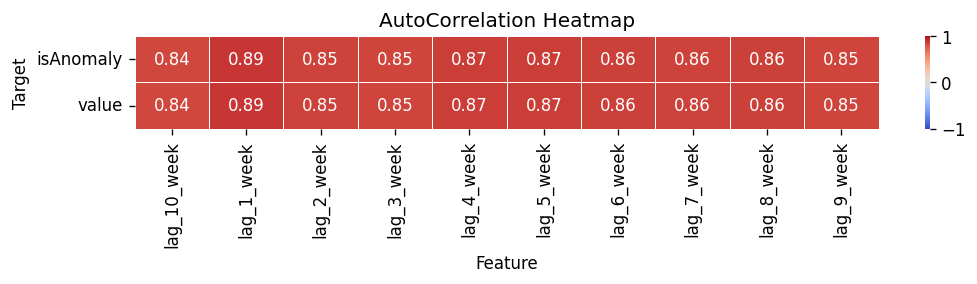

In [860]:
# Filter rows where p-value is less than 0.05
autocorr_results = autocorr_results[autocorr_results['Significant (Autocorr)?']]

# Pivot the DataFrame for heatmap visualization
heatmap_data = autocorr_results.pivot(index='Target', columns='Feature', values='Spearman Autocorrelation')

# Plot the heatmap
plt.figure(figsize=(10, 1))  # Adjust size as needed
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

plt.title('AutoCorrelation Heatmap')
plt.show()


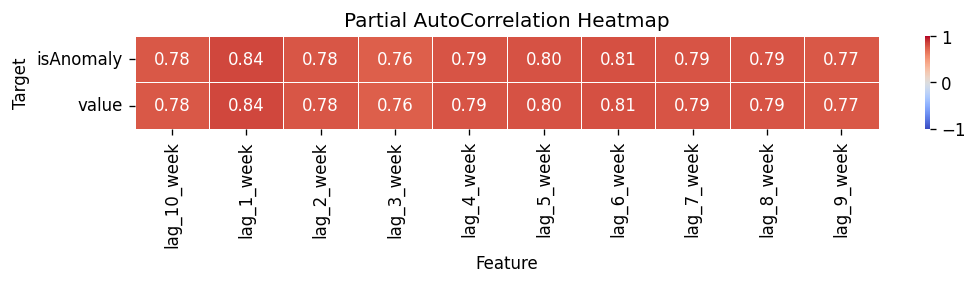

In [861]:
# Filter rows where p-value is less than 0.05
autocorr_results = autocorr_results[autocorr_results['Significant (Partial Corr)?']]

# Pivot the DataFrame for heatmap visualization
heatmap_data = autocorr_results.pivot(index='Target', columns='Feature', values='Spearman Partial Correlation')

# Plot the heatmap
plt.figure(figsize=(10, 1))  # Adjust size as needed
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

plt.title('Partial AutoCorrelation Heatmap')
plt.show()

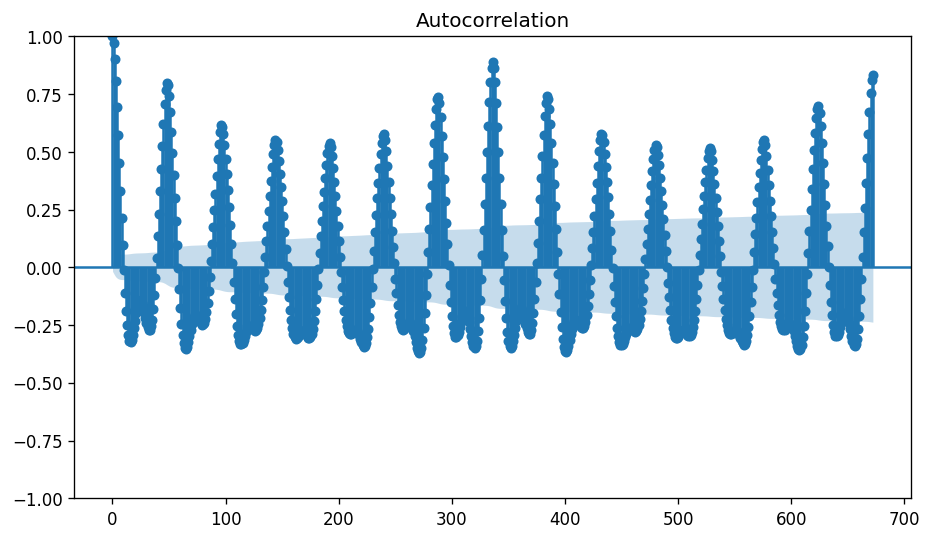

In [862]:
plot_acf(dataset['value'], lags=336 * 2)  # Adjust lags as needed
plt.show()  # Ensure the plot is shown only once

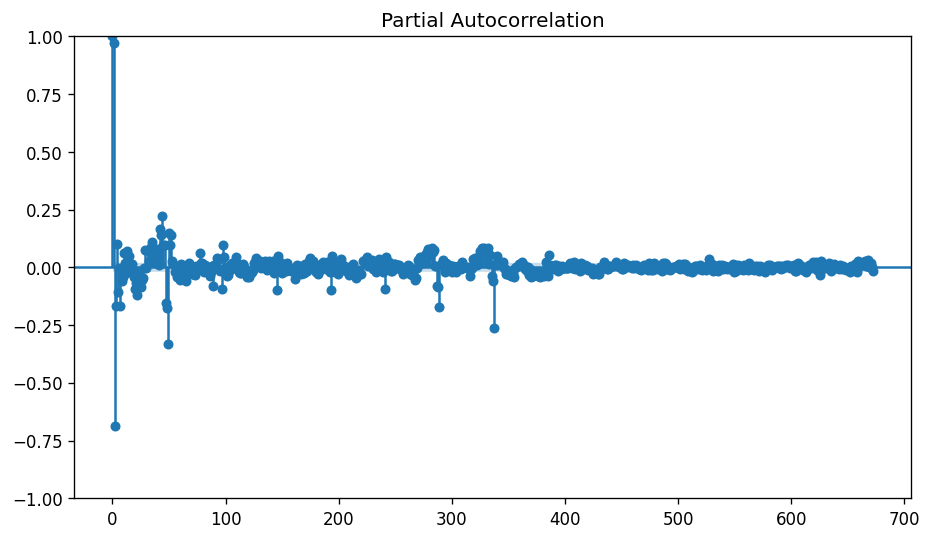

In [863]:
plot_pacf(dataset['value'], lags=336 * 2)  # Adjust lags as needed
plt.show()  # Ensure the plot is shown only once

# Baseline Models

In [885]:
def check_performance():
    y_true = dataset['isAnomaly']
    y_pred_prob = dataset['anomaly']
    precision = precision_score(y_true, y_pred_prob)
    recall = recall_score(y_true, y_pred_prob)
    f1 = f1_score(y_true, y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc}")
    print(classification_report(y_true, y_pred_prob))

Moving Average Baseline

In [886]:
window_size = 2 * 24 * 7  # Adjust based on your dataset
dataset['moving_average'] = dataset['value'].rolling(window=window_size).mean()

# Calculate residuals (difference between actual and smoothed values)
dataset['residuals'] = dataset['value'] - dataset['moving_average']

# Flag anomalies: residuals exceeding a threshold
threshold = 2 * dataset['residuals'].std()  # Example threshold: 2 standard deviations
dataset['anomaly'] = (abs(dataset['residuals']) > threshold).astype(int)
print("Moving Average Baseline Performance")
check_performance()


Moving Average Baseline Performance
AUC: 0.5282308836996337
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      9984
        True       0.20      0.07      0.10       336

    accuracy                           0.96     10320
   macro avg       0.58      0.53      0.54     10320
weighted avg       0.94      0.96      0.95     10320



Z-scores

In [887]:
# Calculate z-scores
dataset['z_score'] = (dataset['value'] - dataset['value'].mean()) / dataset['value'].std()

# Flag anomalies
threshold = 3  # Common threshold for anomaly detection
dataset['anomaly'] = (abs(dataset['z_score']) > threshold).astype(int)
print("Z-scores Performance")
check_performance()


Z-scores Performance
AUC: 0.5014880952380952
              precision    recall  f1-score   support

       False       0.97      1.00      0.98      9984
        True       1.00      0.00      0.01       336

    accuracy                           0.97     10320
   macro avg       0.98      0.50      0.49     10320
weighted avg       0.97      0.97      0.95     10320



Seasonal Decomposition + Residual Threshold

In [888]:
# Decompose the time series
result = seasonal_decompose(dataset['value'], model='additive', period=336)  # Adjust period
residuals = result.resid

# Threshold for anomalies
threshold = 2 * residuals.std()
dataset['anomaly'] = (abs(residuals) > threshold).astype(int)
print("Residual Performance")
check_performance()


Residual Performance
AUC: 0.7325792696886447
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      9984
        True       0.42      0.49      0.45       336

    accuracy                           0.96     10320
   macro avg       0.70      0.73      0.71     10320
weighted avg       0.96      0.96      0.96     10320



Auto-Regressive Integrated Moving Average (ARIMA)

In [889]:
# Train ARIMA model
model = ARIMA(dataset['value'], order=(5, 1, 0))  # Adjust ARIMA order
model_fit = model.fit()

# Generate predictions
dataset['arima_forecast'] = model_fit.fittedvalues

# Calculate residuals and flag anomalies
dataset['residuals'] = dataset['value'] - dataset['arima_forecast']


threshold = 2 * dataset['residuals'].std()
dataset['anomaly'] = (abs(dataset['residuals']) > threshold).astype(int)
print("ARIMA Performance")

mse = mean_squared_error(dataset['value'], dataset['arima_forecast'])
print(f"MSE: {mse}")
check_performance()


C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


ARIMA Performance
MSE: 1525806.1514355997
AUC: 0.49505637591575097
              precision    recall  f1-score   support

       False       0.97      0.95      0.96      9984
        True       0.03      0.04      0.03       336

    accuracy                           0.92     10320
   macro avg       0.50      0.50      0.50     10320
weighted avg       0.94      0.92      0.93     10320

